# 0.0. IMPORTS

In [245]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime as dt


from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



warnings.filterwarnings( 'ignore' )



### 0.1. Helper functions

In [246]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) &(x_training['date'] <= validation_end_date)]
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )




def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


In [247]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading data

In [248]:
conda update -n base -c defaults conda


Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [249]:
df_sales_raw = pd.read_csv ('train.csv', low_memory=False)

In [250]:
df_store_raw = pd.read_csv ('store.csv', low_memory=False)

In [251]:
# Merge

In [252]:
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

In [253]:
#Verificando o merge

In [254]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
317675,1057,1,2014-10-06,8008,731,1,1,0,0,d,c,3230.0,11.0,2011.0,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [255]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

 ## 1.1. Rename Columns

In [256]:
df1 = df_raw.copy()

In [257]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

In [258]:
# Verificando Rename método snakecase
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [259]:
df1.shape

(1017209, 18)

## 1.3. Data types

In [260]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [261]:
#Alterando formato data
df1['date'] = pd.to_datetime (df1['date'])

In [262]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA's

In [263]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA's

In [264]:
#competition_distance verificando valor maximo atual
df1 ['competition_distance'].max()

75860.0

In [265]:
#competition_distance
df1 ['competition_distance'] = df1 ['competition_distance'].apply( lambda x: 200000.0 if math.isnan (x) else x)

#competition_open_since_month  
df1 ['competition_open_since_month'] = df1.apply (lambda x: x ['date'].month if math.isnan (x ['competition_open_since_month']) else x ['competition_open_since_month'], axis=1)

#competition_open_since_year
df1 ['competition_open_since_year'] = df1.apply (lambda x: x ['date'].year if math.isnan (x ['competition_open_since_year']) else x ['competition_open_since_year'], axis=1)
                             
#promo2_since_week 
df1 ['promo2_since_week'] = df1.apply (lambda x: x ['date'].week if math.isnan (x ['promo2_since_week']) else x ['promo2_since_week'], axis=1)

#promo2_since_year
df1 ['promo2_since_year'] = df1.apply (lambda x: x ['date'].year if math.isnan (x ['promo2_since_year']) else x ['promo2_since_year'], axis=1)

#promo_interval 
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1 ['promo_interval'].fillna(0, inplace =True)
df1 ['month_map'] = df1 ['date'].dt.month.map(month_map)
df1 ['is_promo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x ['promo_interval'] == 0 else 1 if x ['month_map'] in x ['promo_interval'].split (',') else 0, axis=1)

In [266]:
#Verificando coluna criada month_map
df1.sample(5).T

,143962,518914,108914,724269,765731
store,128,110,760,305,512
day_of_week,2,7,6,5,3
date,2015-03-24 00:00:00,2014-03-23 00:00:00,2015-04-25 00:00:00,2013-09-20 00:00:00,2013-08-14 00:00:00
sales,6351,0,8490,3809,5033
customers,545,0,1434,373,1103
open,1,0,1,1,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,d,a,a,c,b


In [267]:
# Verificando alteracoes NA's
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [268]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [269]:
# Convertendo de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [270]:
#Verificando correcoes
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [271]:
num_attributes = df1.select_dtypes (include = ['int64','int32', 'float64'])
cat_attributes = df1.select_dtypes (exclude = ['int64', 'float64','int32','datetime64[ns]'])

In [272]:
#Verificando
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
617022,98,3,0,0,0,0,1,15140.0,12,2006,1,1,2012,0
943878,259,4,9538,2049,1,1,0,210.0,3,2013,0,10,2013,0


In [273]:
#Verificando
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
195228,0,a,a,0,Fev
709609,a,a,c,"Jan,Apr,Jul,Oct",Oct


### 1.7.1 Numerical Attributes

In [274]:
#Central Tendency - Mean and Median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () )).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis () )).T

#Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Density'>

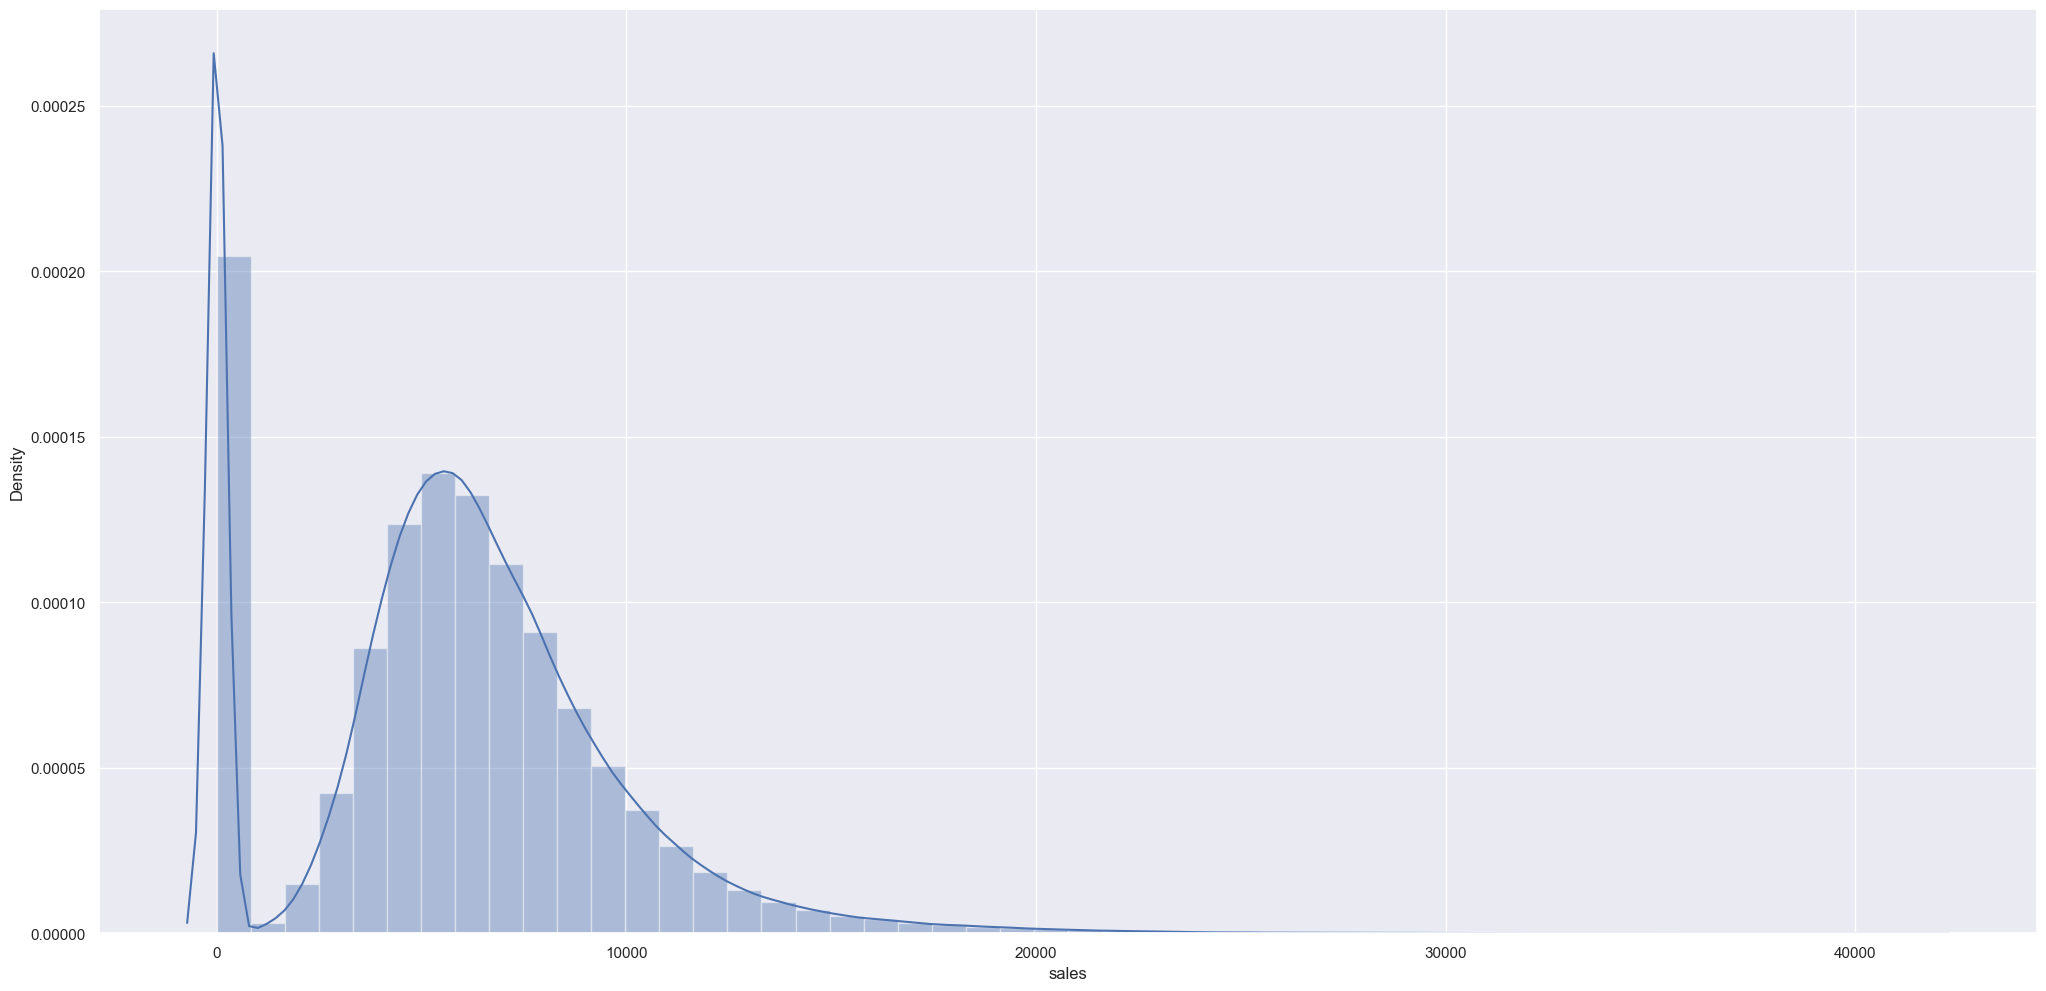

In [275]:
sns.distplot (df1['sales'])

<Axes: xlabel='competition_distance', ylabel='Density'>

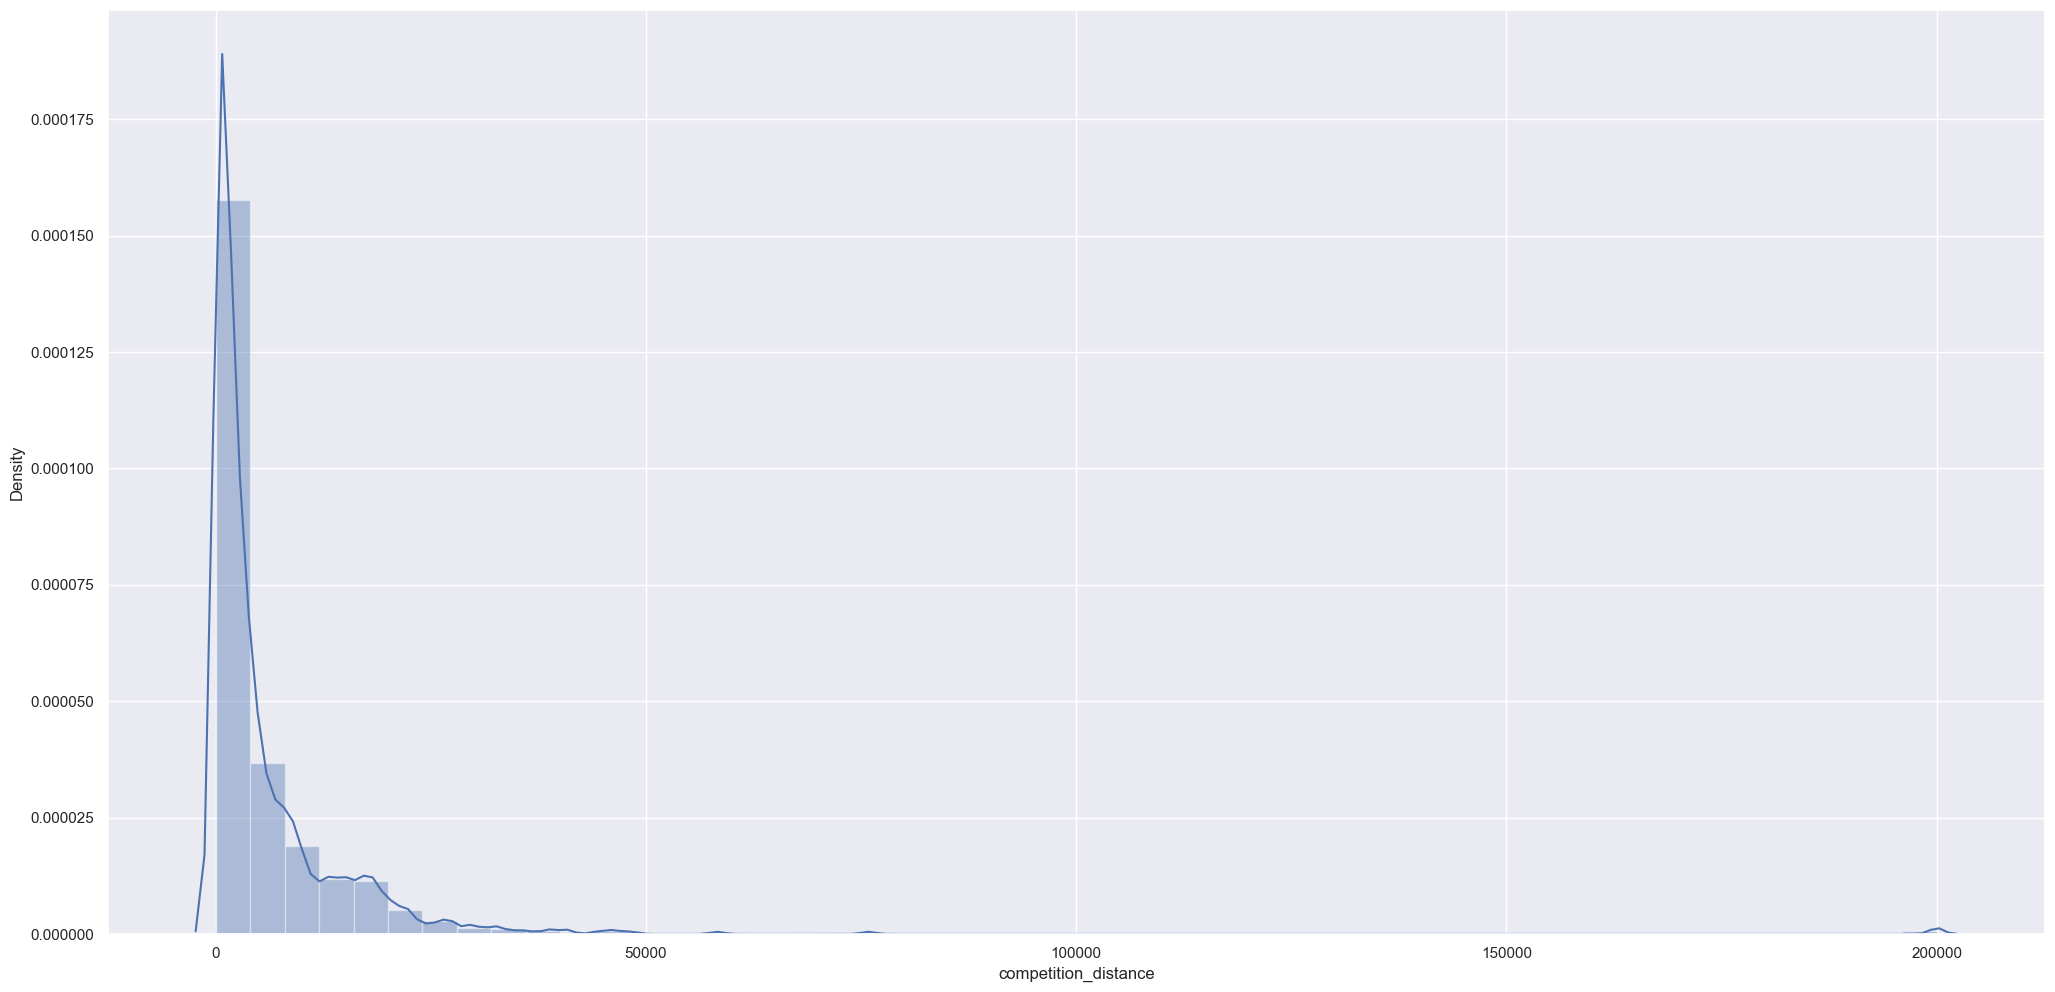

In [276]:
sns.distplot (df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [277]:
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

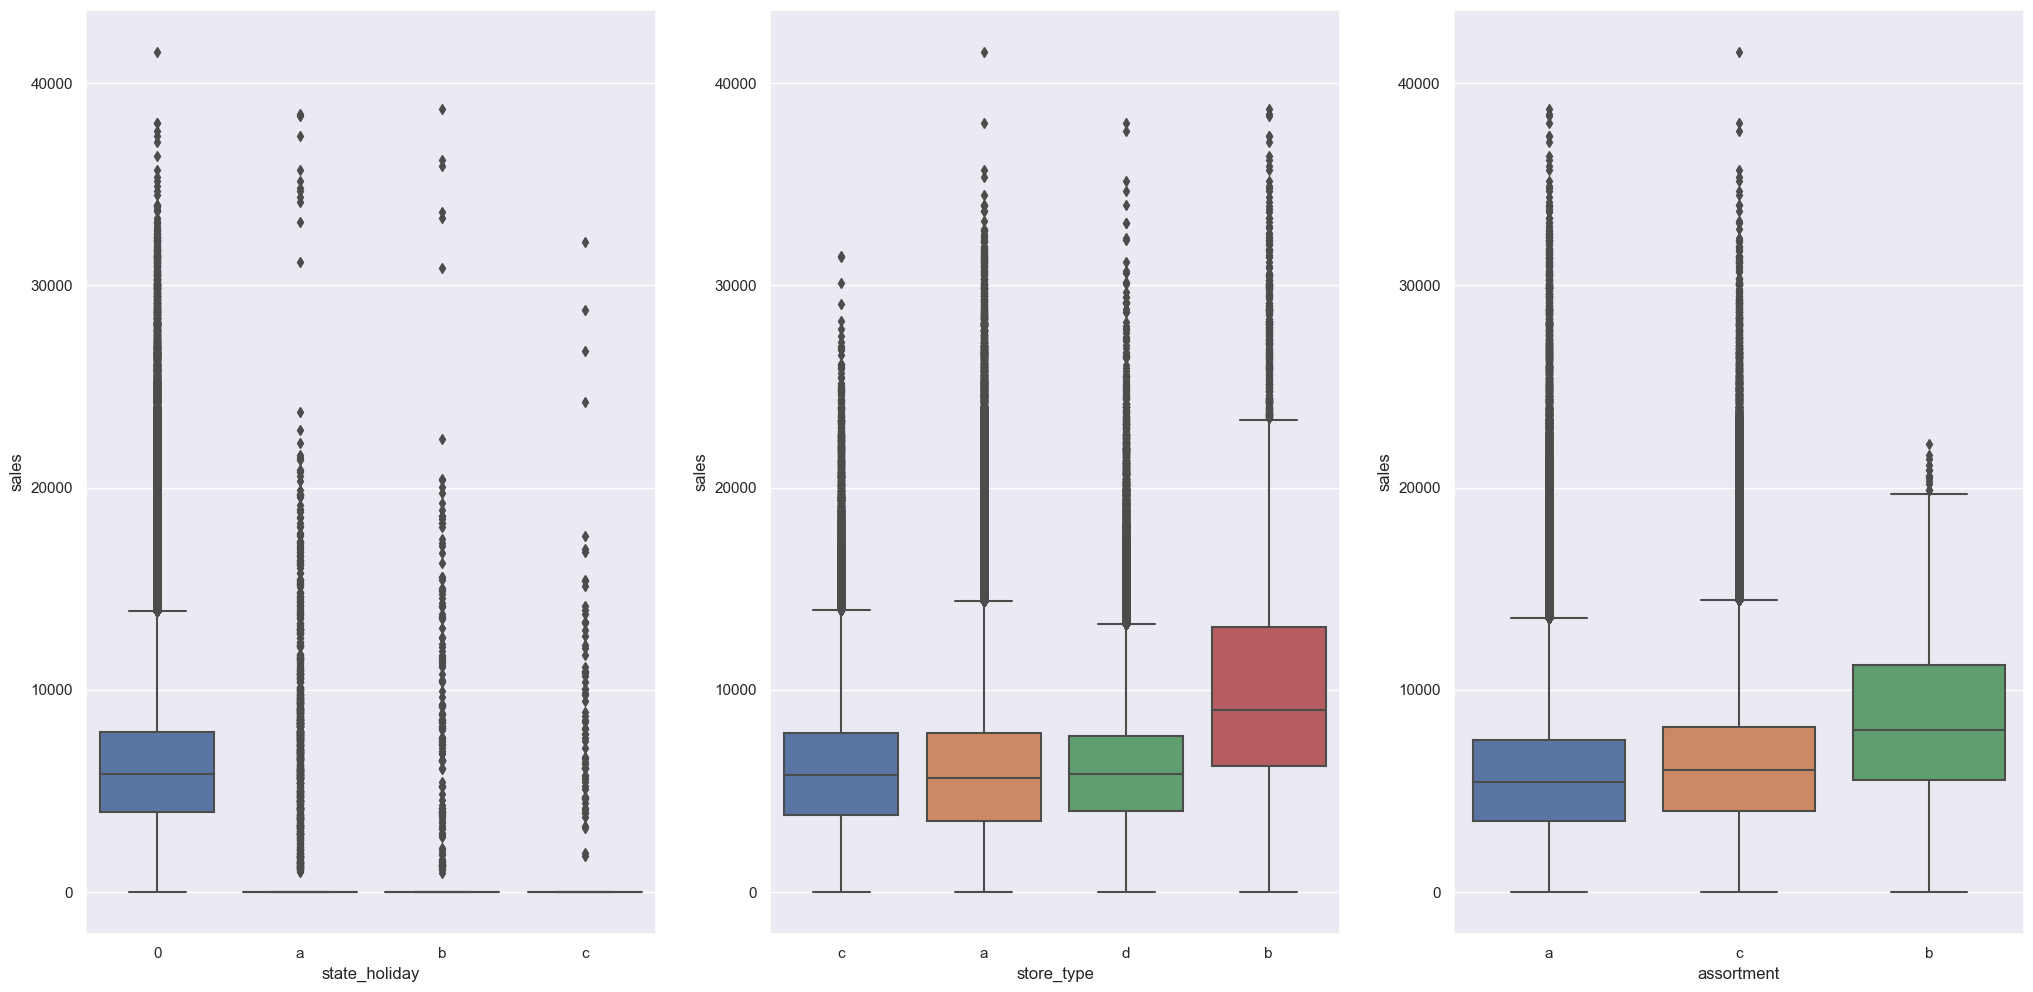

In [278]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0) ]

plt.subplot(1,3,1)
sns.boxplot (x='state_holiday', y='sales',data=df1)

plt.subplot(1,3,2)
sns.boxplot (x='store_type', y='sales',data=df1)

plt.subplot(1,3,3)
sns.boxplot (x='assortment', y='sales',data=df1)


# 2.0. FEATURE ENGENEERING

In [279]:
df2 = df1.copy ()

### 2.1 Mapa mental de hipóteses

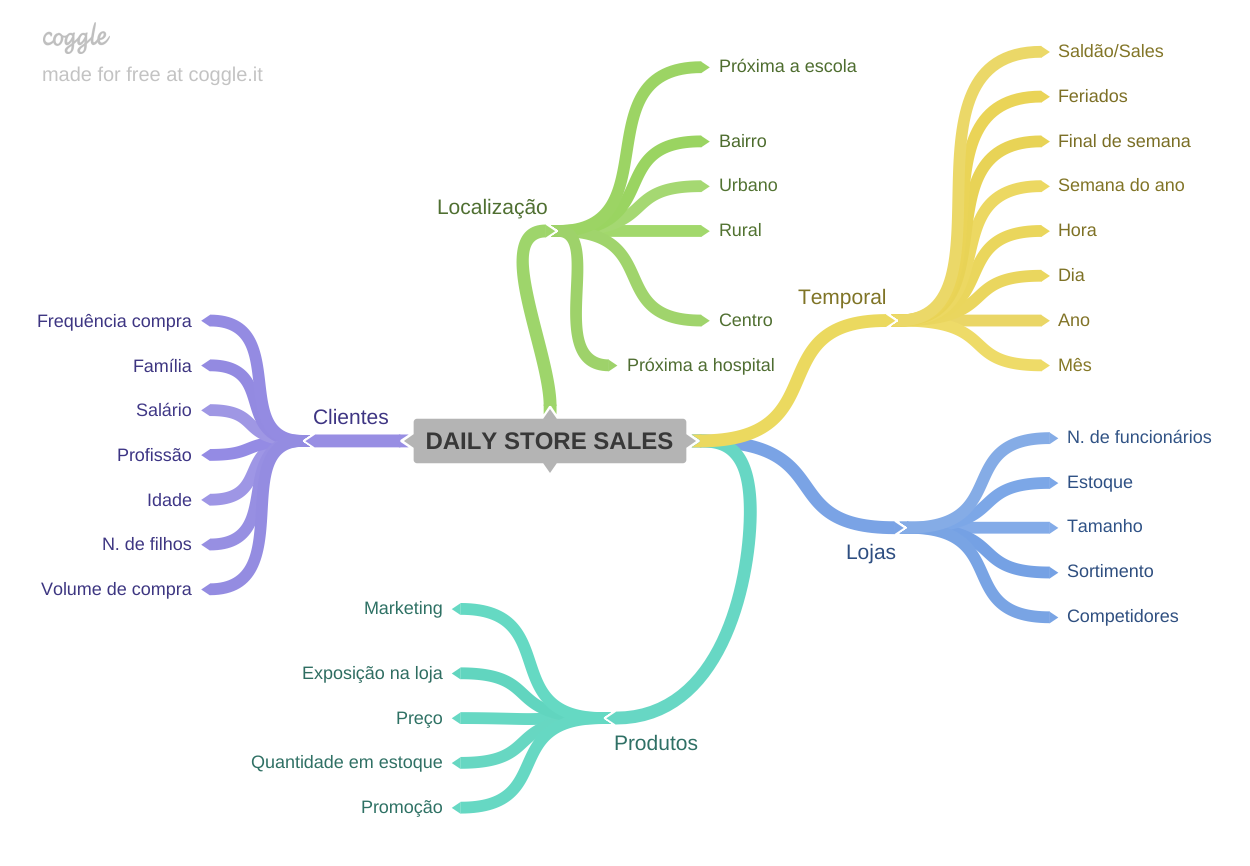

In [280]:
Image ('mapa_hipoteses.png')

### 2.2 Criação das hipóteses

#### 2.2.1 Hipóteses Loja

##### 1. Lojas com maior quadro de funcionários deveriam vender mais.

##### 2. Lojas com maior estoque deveriam vender mais.

##### 3. Lojas com maior porte deveriam vender mais.

##### 4. Lojas com menor porte deveriam vender menos.

##### 5. Lojas com maior sortimento deveriam vender mais.

##### 6 .Lojas com competidores a mais tempo deveriam vender mais.

##### 7 .Lojas com competidores mais próximos deveriam vender menos.

#### 2.2.2 Hipóteses Produto

##### 1. Lojas que investem mais em marketing deveriam vender mais.

##### 2. Lojas que expõe mais o produto nas vitrines deveriam vender mais.

##### 3. Lojas com menores preços deveriam deveriam vender mais.

##### 4. Lojas com preços menores nos produtos por mais tempo deveriam vender mais.

##### 5. Lojas com promos mais agressivas, deveriam vender mais.

##### 6 .Lojas com mais dias de promoção deveriam vender mais.

##### 7 .Lojas com mais promoções consecutivas deveriam vender mais.


#### 2.2.3 Hipóteses Tempo

##### 1.Lojas que tem mais feriados deveriam vender menos.

##### 2.Lojas que abrem nos primeiros 6 meses deveriam vender mais.

##### 3.Lojas que abrem nos finais de semana deveriam vender mais.

##### 4..Lojas abertas durante o feriado de natal deveriam vender mais.

##### 5.Lojas deveriam vender mais a longo dos anos.

##### 6 .Lojas deveriam vender mais no segundo semestre do ano.

##### 7.Lojas deveriam vender mais depois do dia 10 de cada mês.

### 2.3 Lista Final das hipóteses (Hipóteses que temos dados para comprovar)

##### 1. Lojas com maior sortimento deveriam vender mais.

##### 2 .Lojas com competidores a mais tempo deveriam vender mais.

##### 3 .Lojas com competidores mais próximos deveriam vender menos.

##### 4 .Lojas com mais dias de promoção deveriam vender mais.

##### 5 .Lojas com mais promoções consecutivas deveriam vender mais.

##### 6.Lojas que tem mais feriados deveriam vender menos.

##### 7.Lojas que abrem nos primeiros 6 meses deveriam vender mais.

##### 8.Lojas que abrem nos finais de semana deveriam vender mais.

##### 9..Lojas abertas durante o feriado de natal deveriam vender mais.

##### 10.Lojas deveriam vender mais a longo dos anos.

##### 11 .Lojas deveriam vender mais no segundo semestre do ano.

##### 12.Lojas deveriam vender mais depois do dia 10 de cada mês.

### 2.4 Feature Engineering

In [281]:
#year
df2 ['year'] = df2['date'].dt.year

#month
df2 ['month'] = df2['date'].dt.month

#day
df2 ['day'] = df2['date'].dt.day

#week of year
df2 ['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2 ['year_week'] = df2['date'].dt.strftime ('%Y-%W')

#competition since
df2 ['competition_since'] = df2.apply ( lambda x: dt.datetime (year=x ['competition_open_since_year'], month=x ['competition_open_since_month'], day=1  ), axis=1)
df2['competition_time_month'] = (( df2 ['date'] - df2 ['competition_since'] ) /30).apply (lambda x: x.days).astype(int)

#promo since
df2 ['promo_since'] = df2 ['promo2_since_year'].astype(str) + '-' + df2 ['promo2_since_week'].astype(str)
df2 ['promo_since'] = df2 ['promo_since'].apply (lambda x: dt.datetime.strptime (x + '-1', '%Y-%W-%w') - dt.timedelta (days=7))
df2 ['promo_time_week'] = ((df2['date'] - df2 ['promo_since'])/7).apply (lambda x: x.days).astype(int)

#assortment
df2 ['assortment'] = df2 ['assortment'].apply (lambda x: 'basic' if x== 'a' else 'extra' if x== 'b' else 'extended')

#state holiday
df2 ['state_holiday'] = df2 ['state_holiday'].apply (lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x== 'c' else 'regular_day')

In [282]:
#Verificando
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIAVEIS

In [283]:
df3 = df2.copy()

In [284]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [285]:
df3 = df3[(df3 ['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [286]:
cols_drop = ['customers','open','promo_interval','month_map']

In [287]:
df3 = df3.drop (cols_drop, axis=1)

In [288]:
#Verificando se as colunas foram excluidas
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EDA - ANALISE EXPLORATORIA DOS DADOS

In [289]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

<Axes: xlabel='sales'>

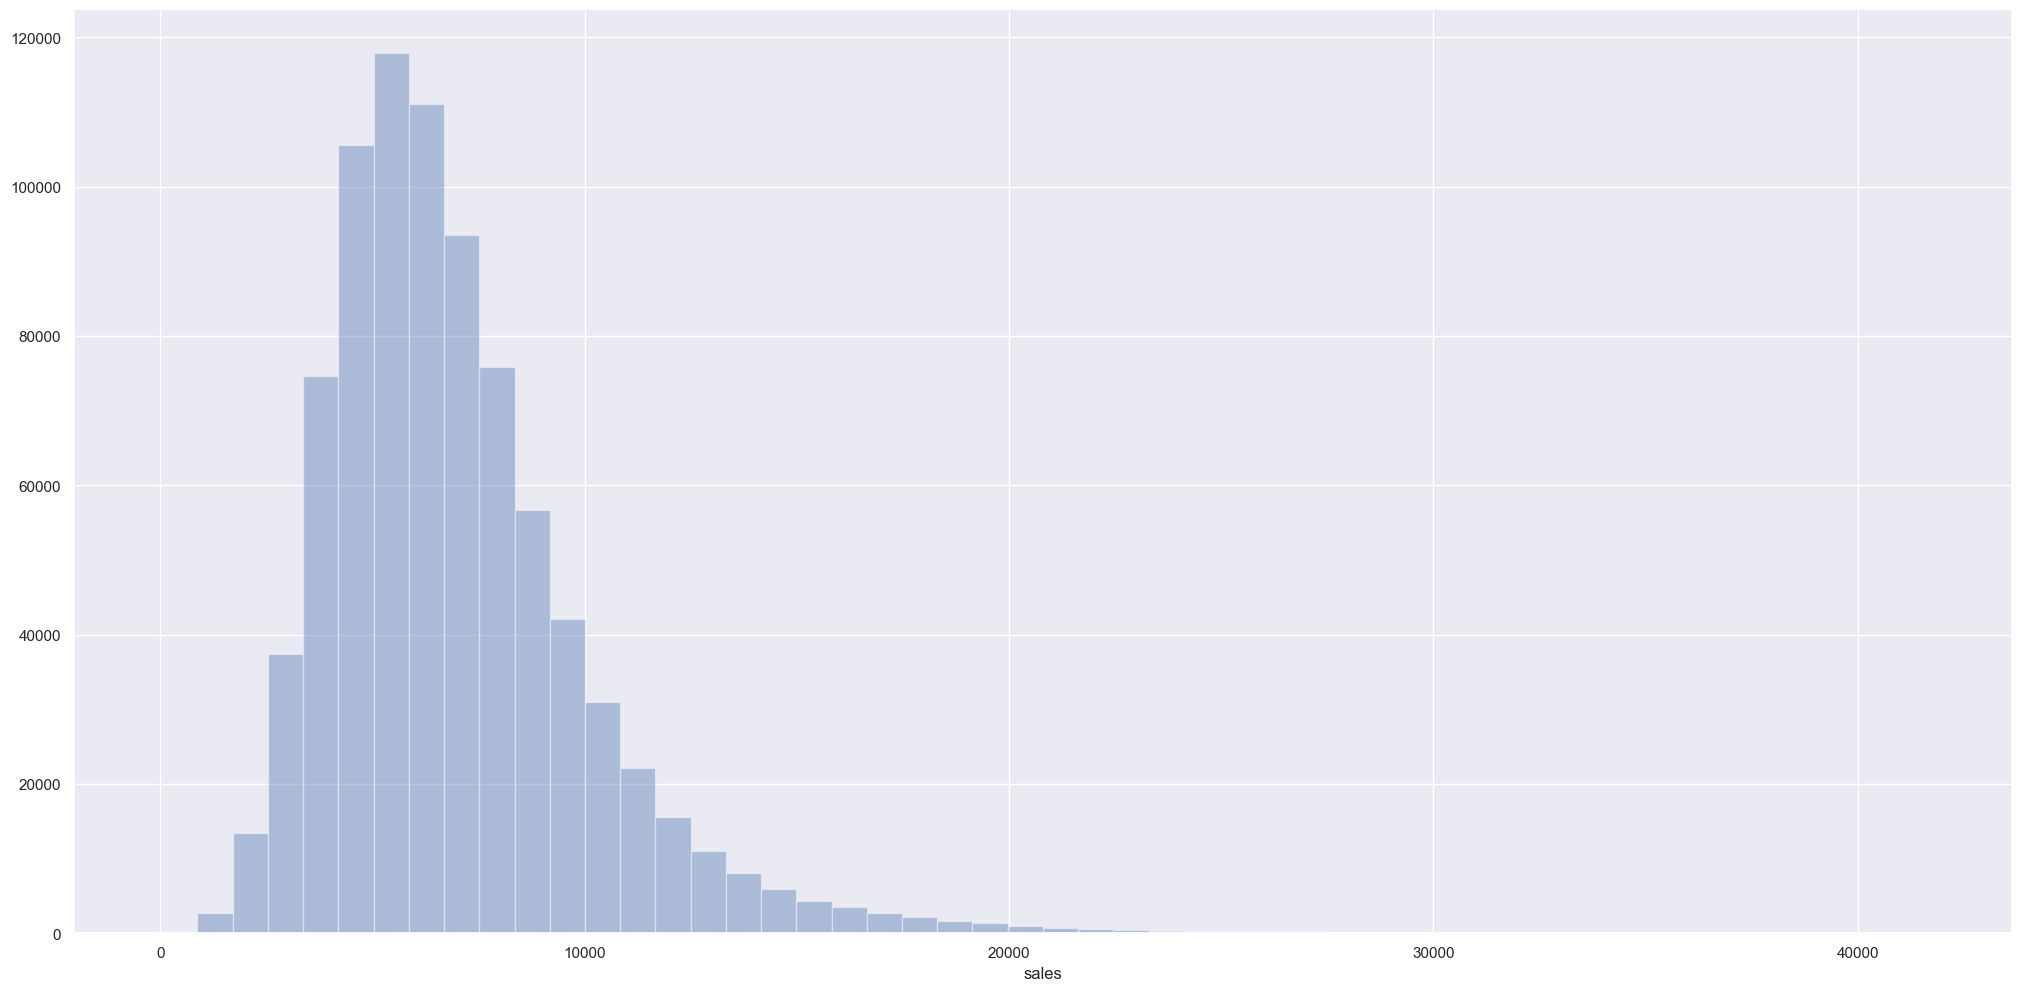

In [290]:
sns.distplot (df4['sales'], kde=False)

### 4.1.2 Numerical Variable

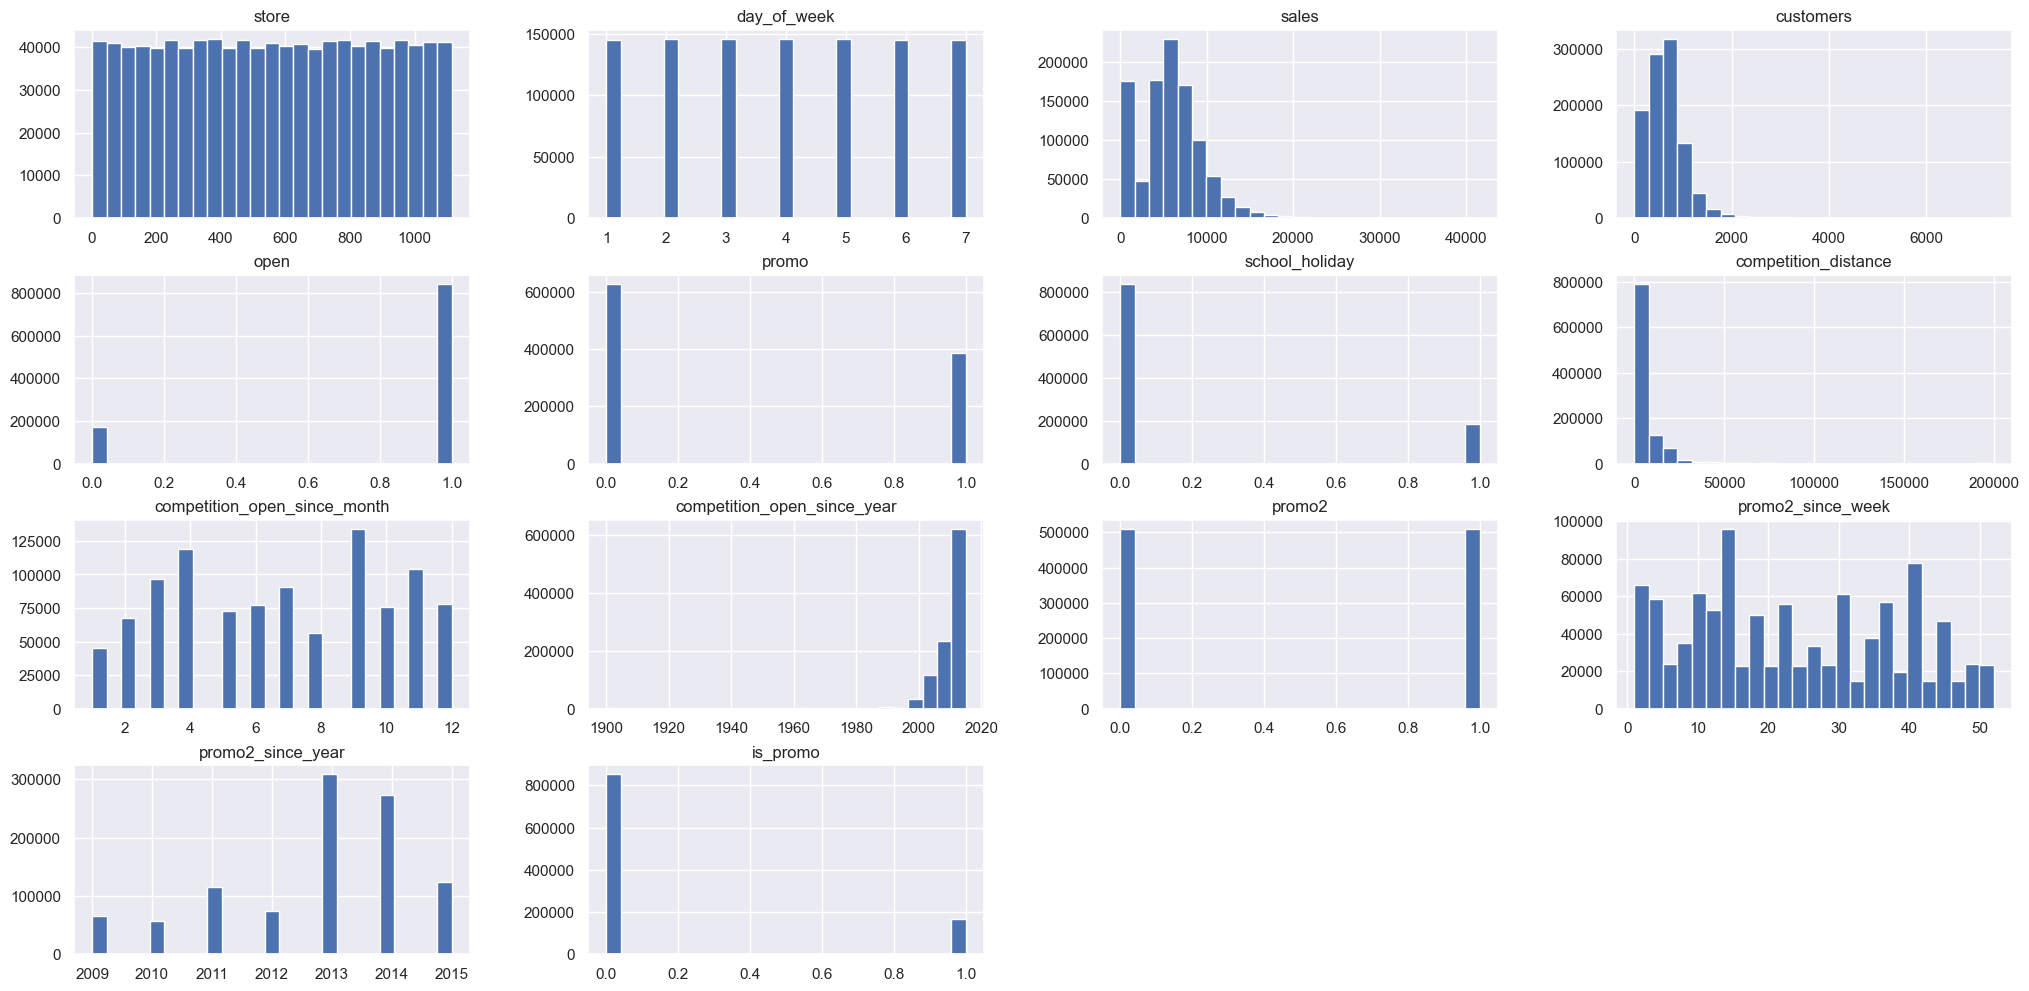

In [291]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [292]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [293]:
#Verificando
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [294]:
#Verificando
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [295]:
#Verificando
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

KeyError: 0

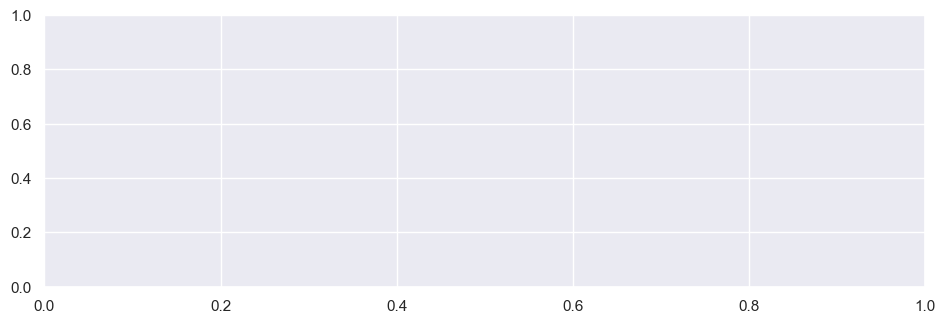

In [296]:
#State Holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#Store Type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Analise Bivariada

### H1 - Lojas com maior sortimento deveriam vender mais.
**False** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

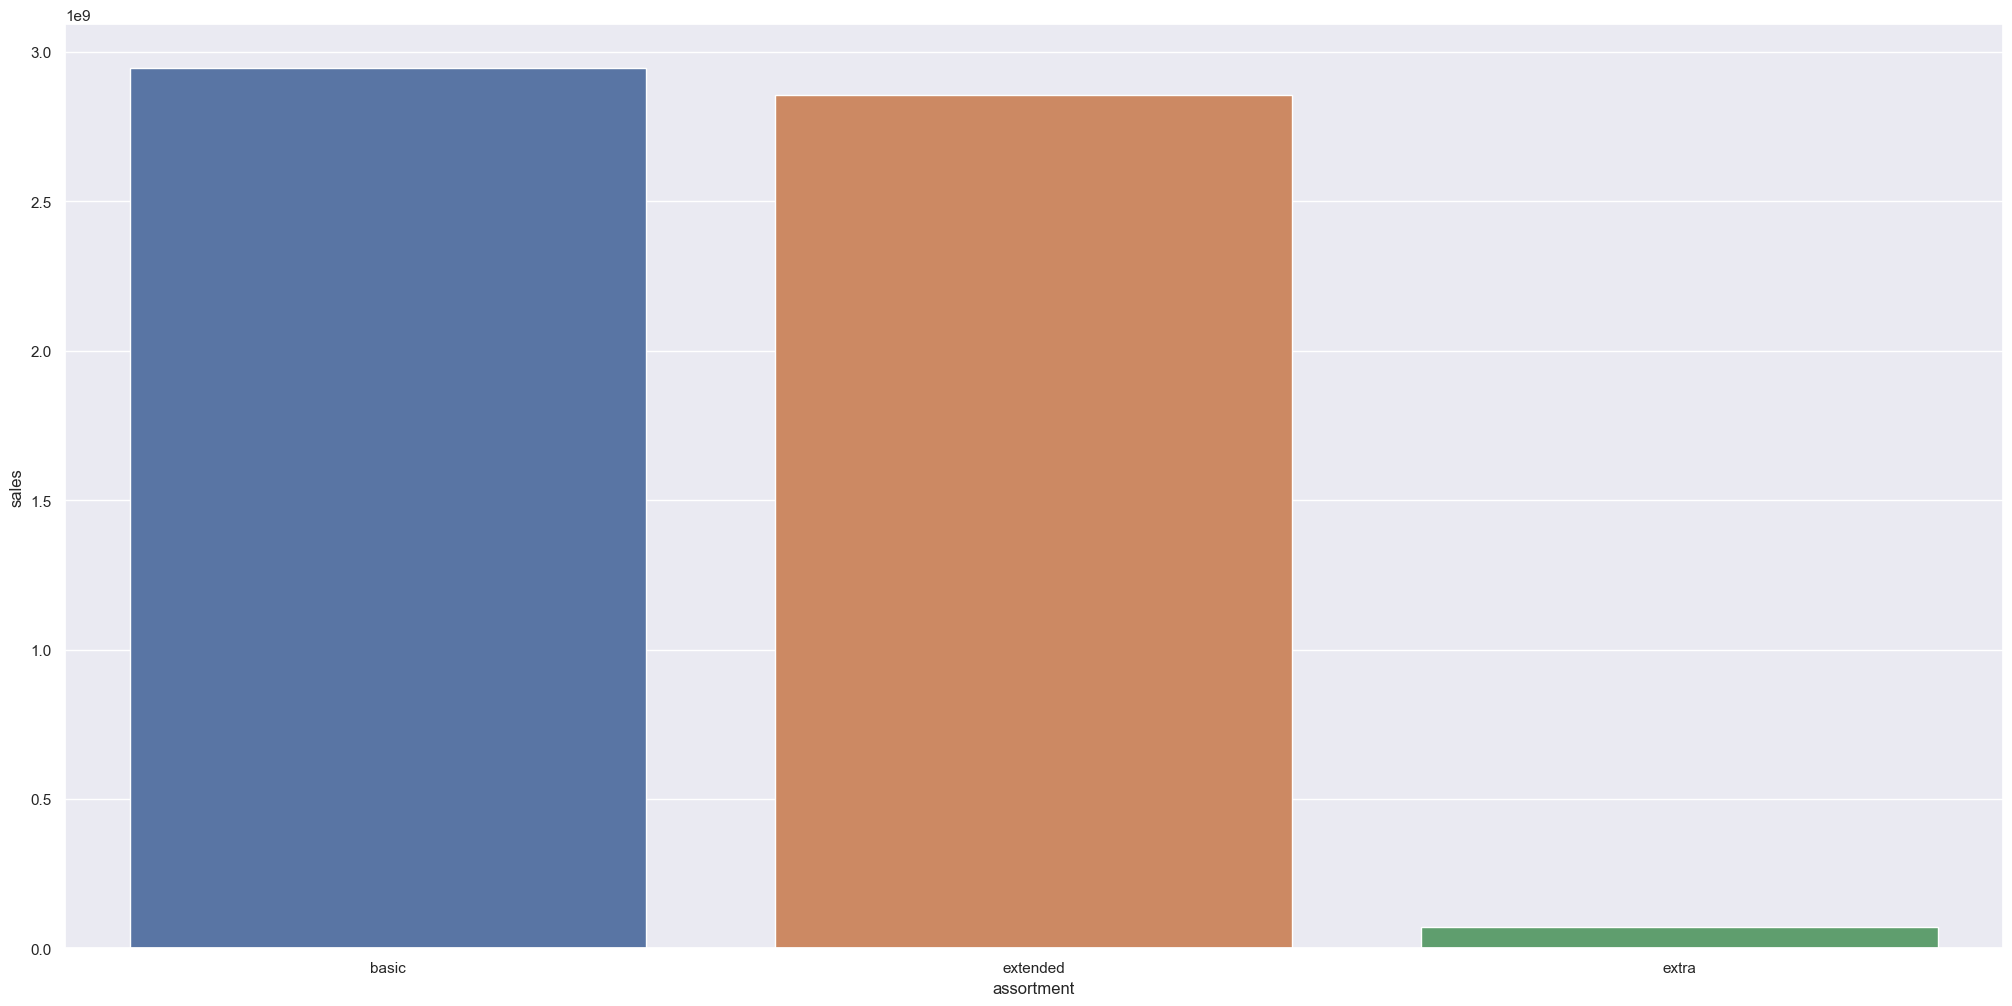

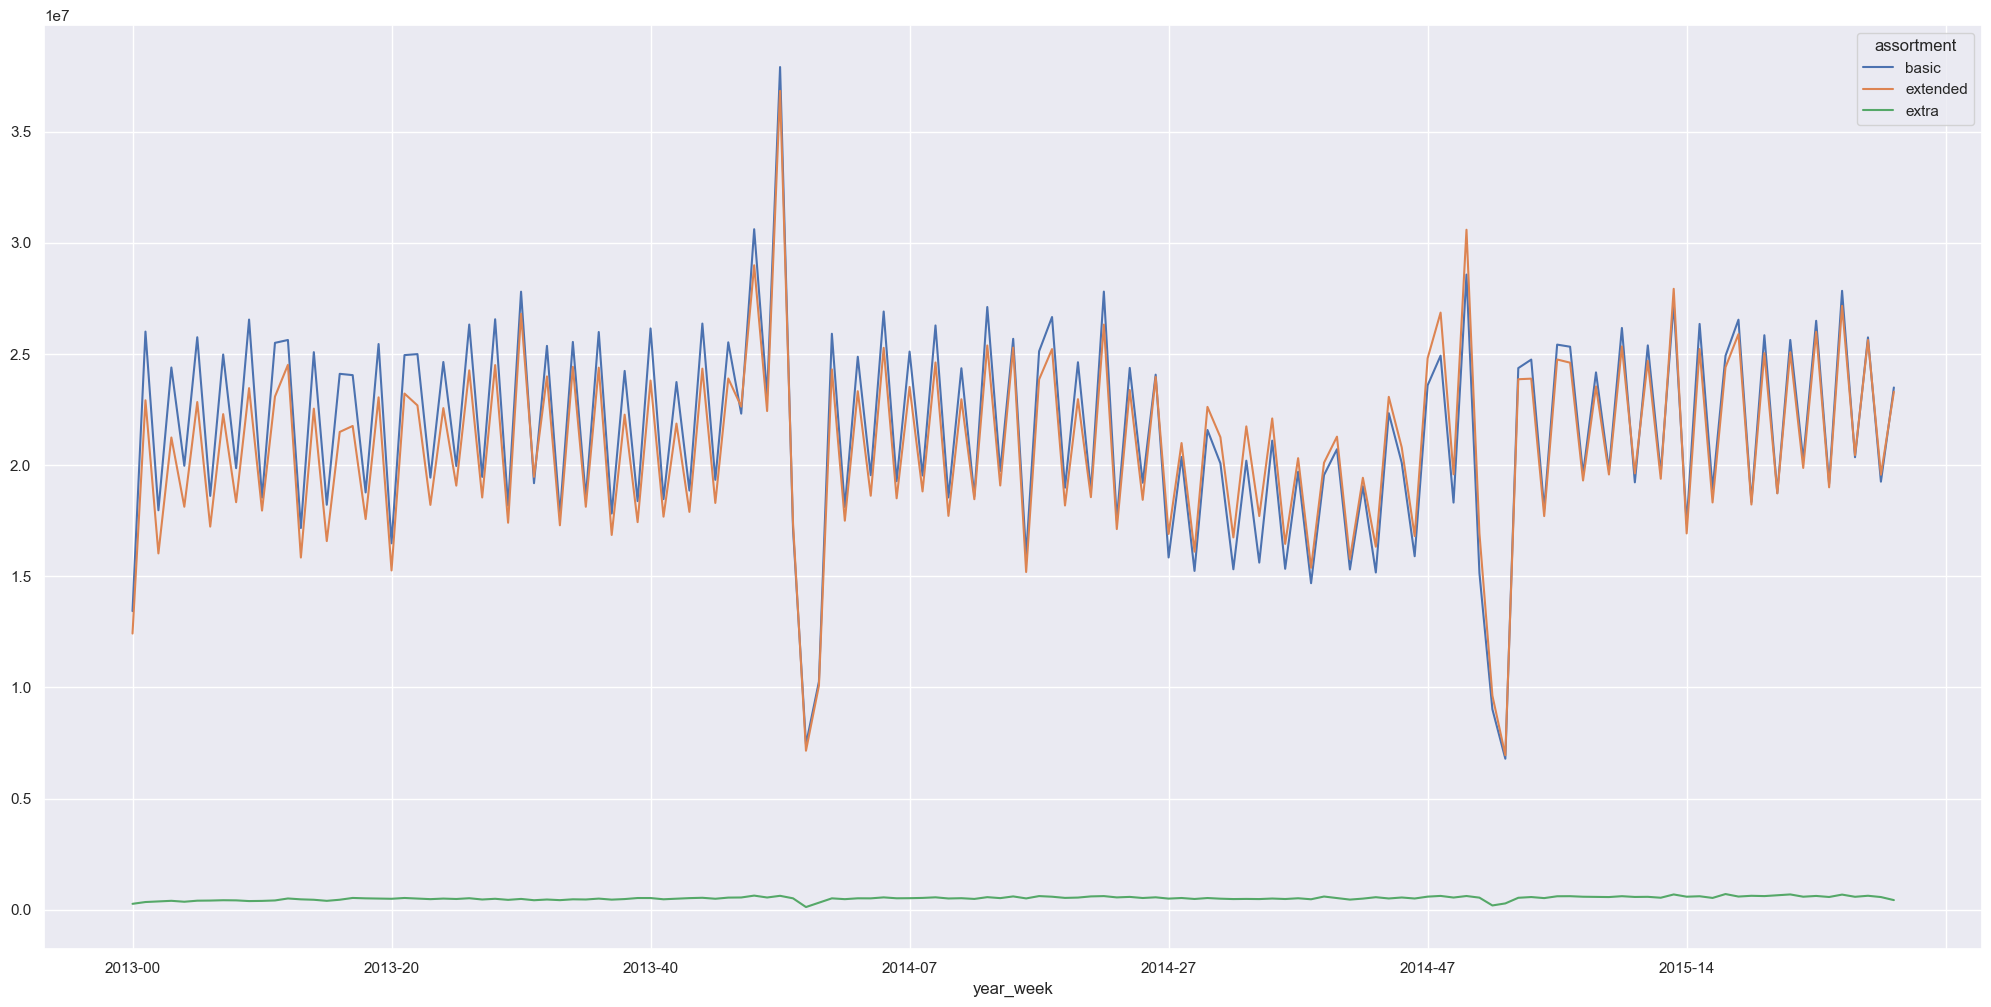

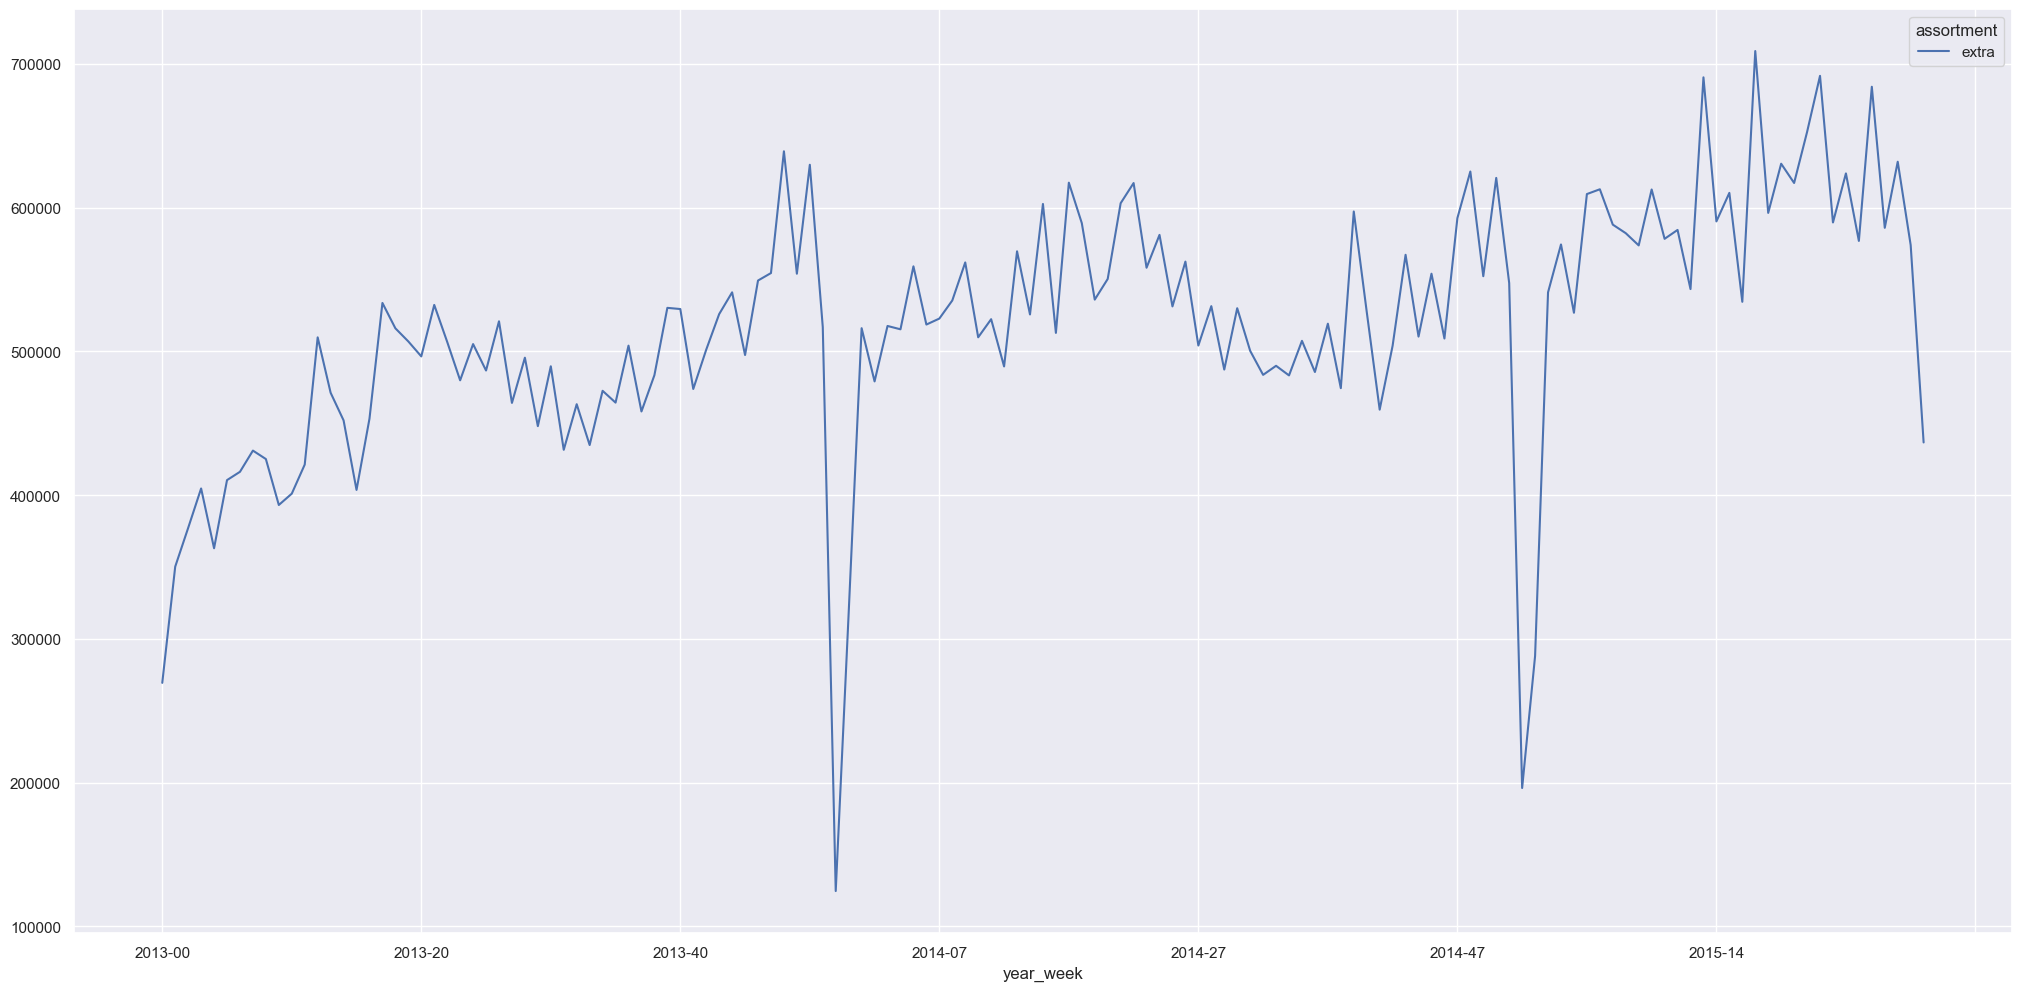

In [297]:
aux1 = df4 [['assortment','sales']].groupby ('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4 [['year_week','assortment','sales']].groupby (['year_week','assortment']).sum().reset_index()
aux2.pivot (index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot (index='year_week', columns='assortment', values='sales').plot()

### H2 - Lojas com competidores mais proximos, deveriam vender menos.
**False** Lojas com competidores mais proximos, na verdade vendem MAIS.

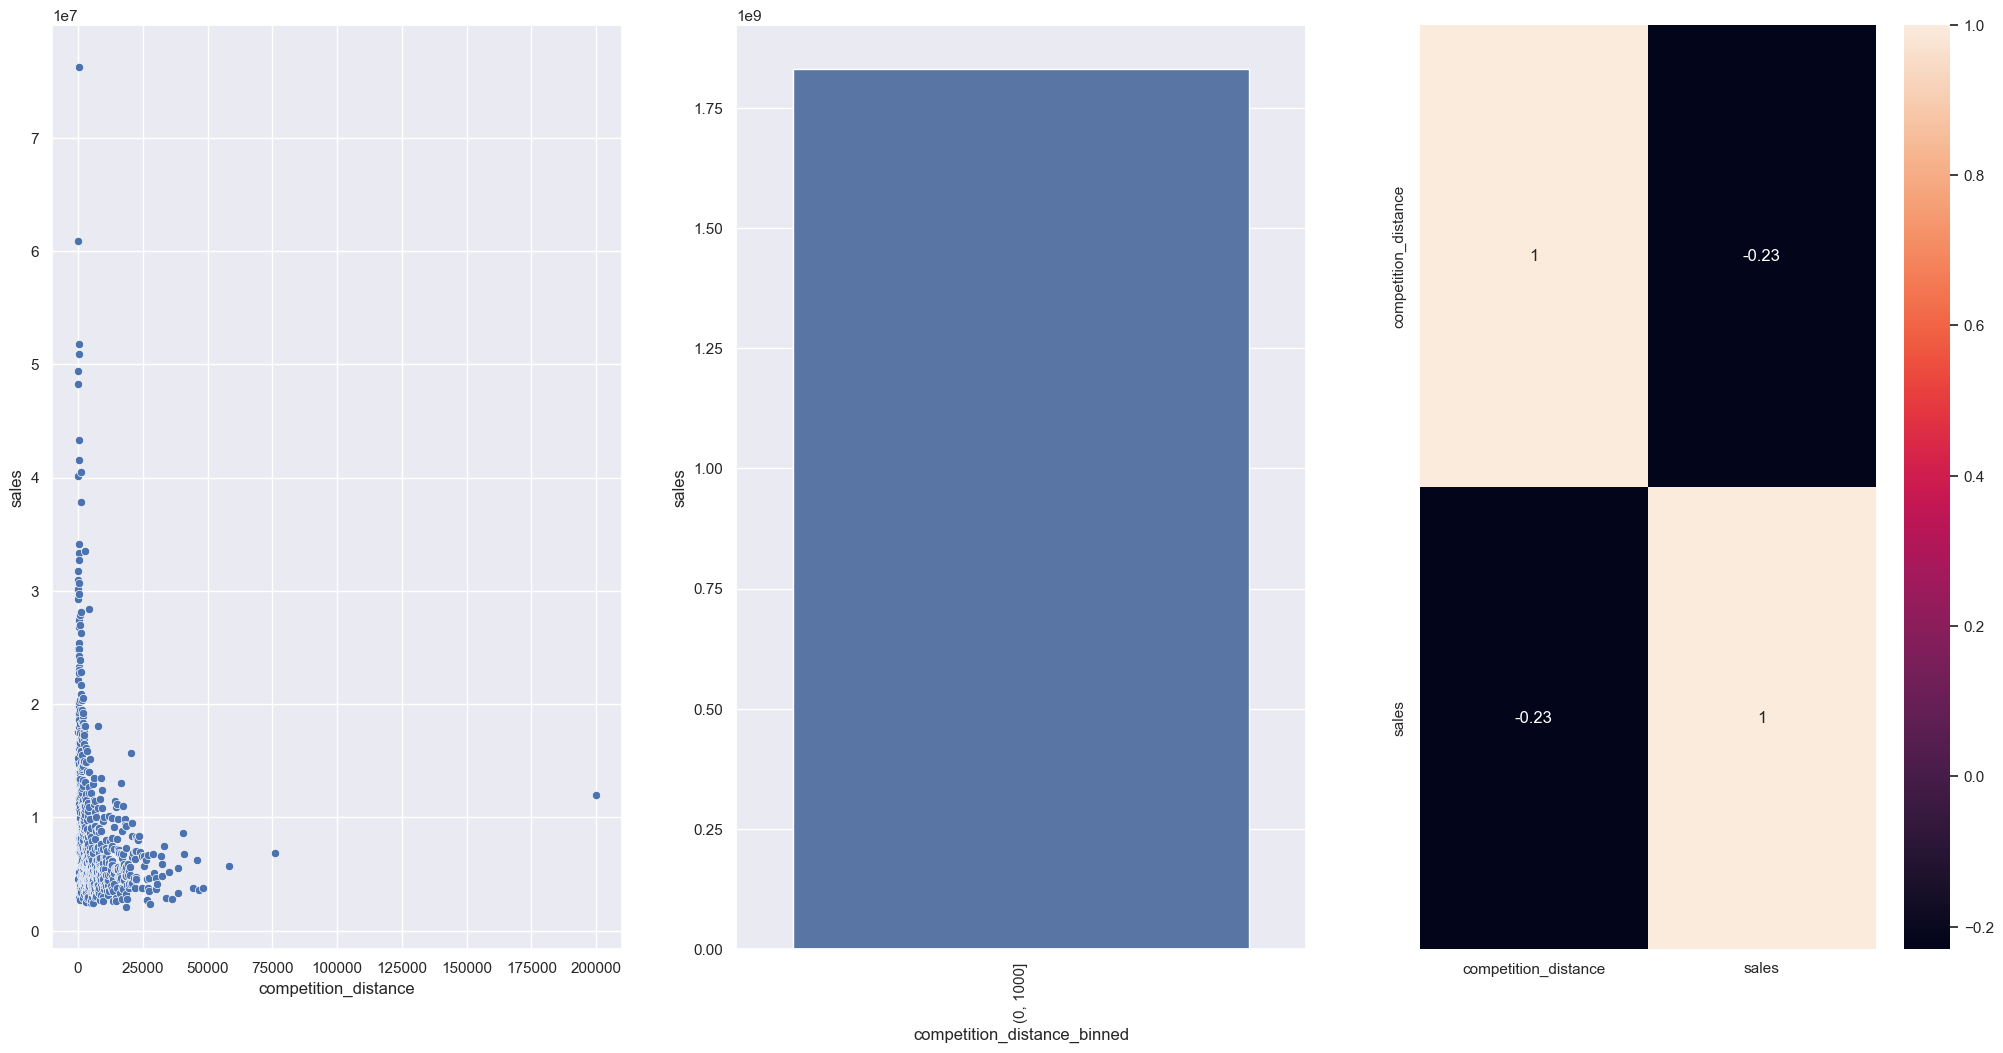

In [298]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
#Grafico 2 nao plotou da forma correta.
bins = list(np.arange(0, 2000, 1000 ))
aux1 ['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
#Rotacionando a legenda eixo y
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3 - Lojas com competidores a mais tempo, deveriam vender mais.
**False** Lojas com competidores ha mais tempo, na verdade vendem MENOS.

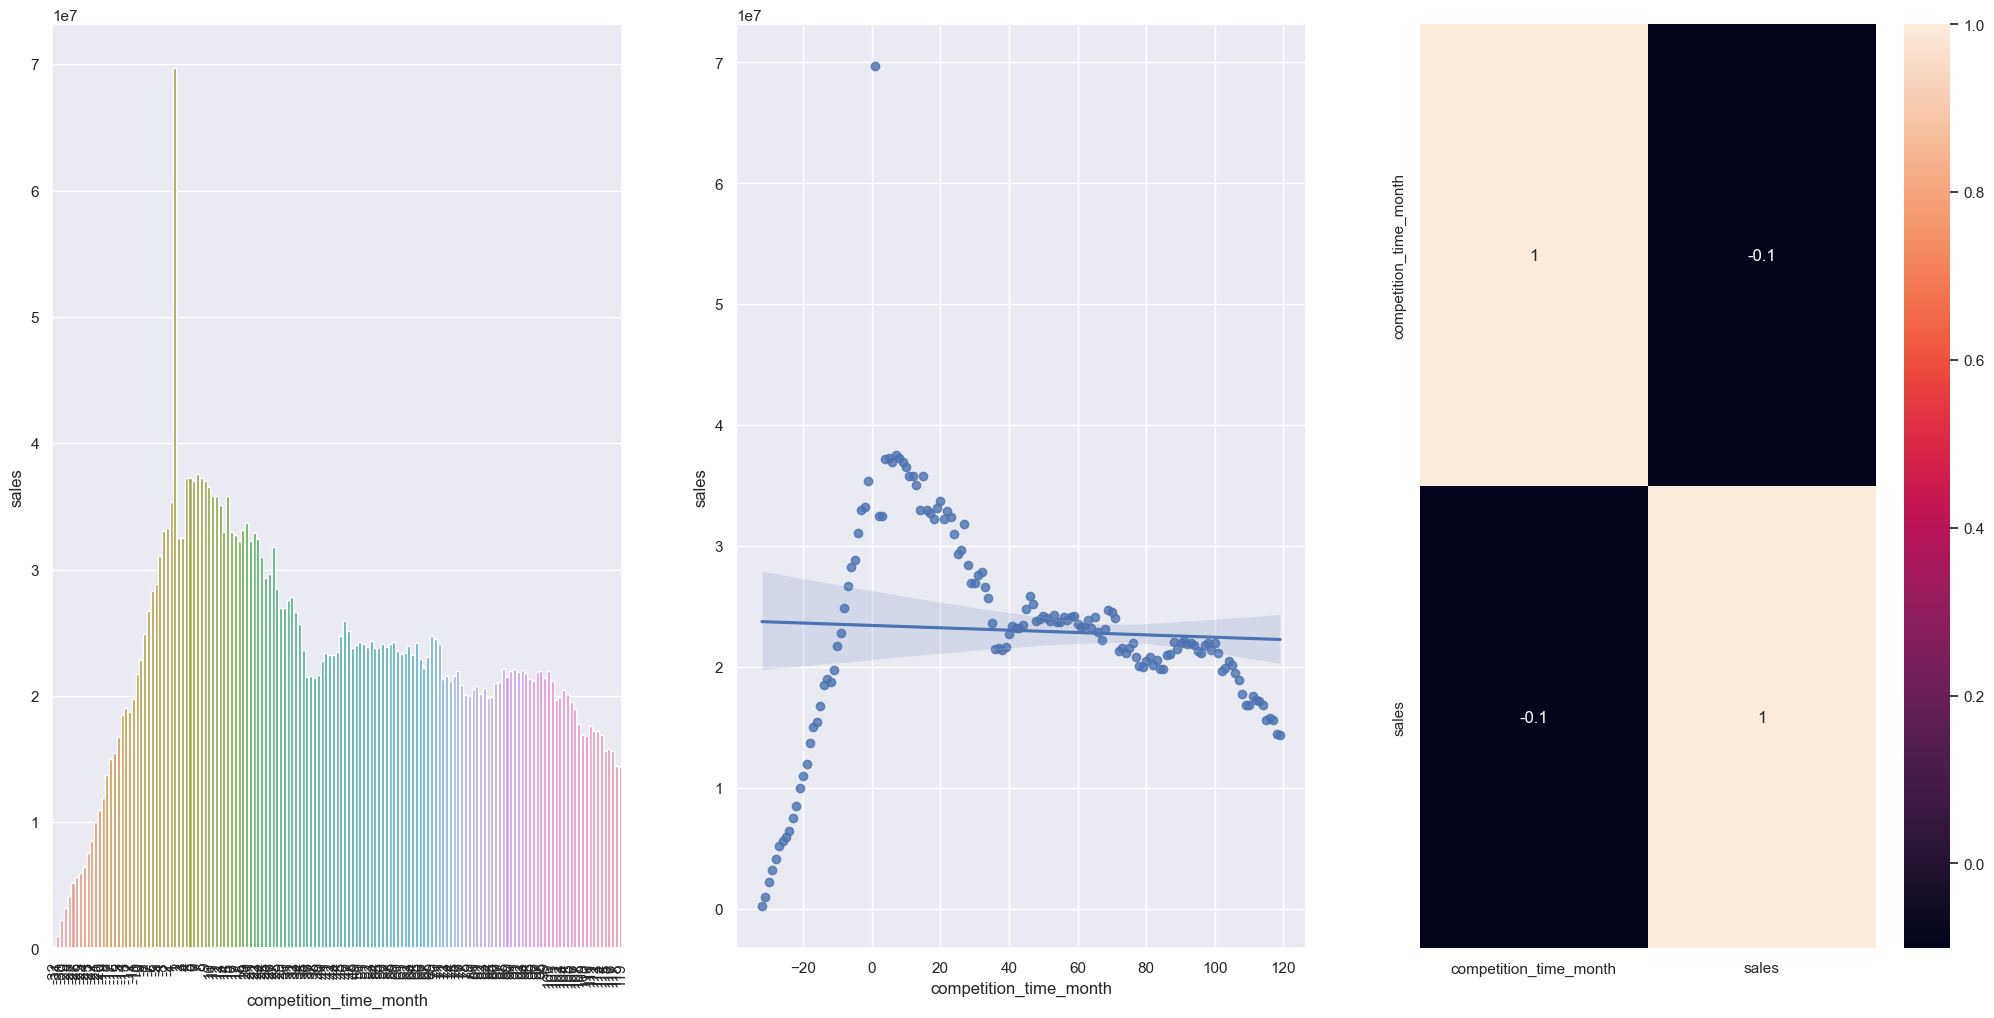

In [299]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1 [(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4 - Lojas com promoçoes ativas por mais tempo, deveriam vender mais.
**False** Lojas com promocoes ativas por mais tempo, na verdade vendem MENOS depois de um certo tempo.

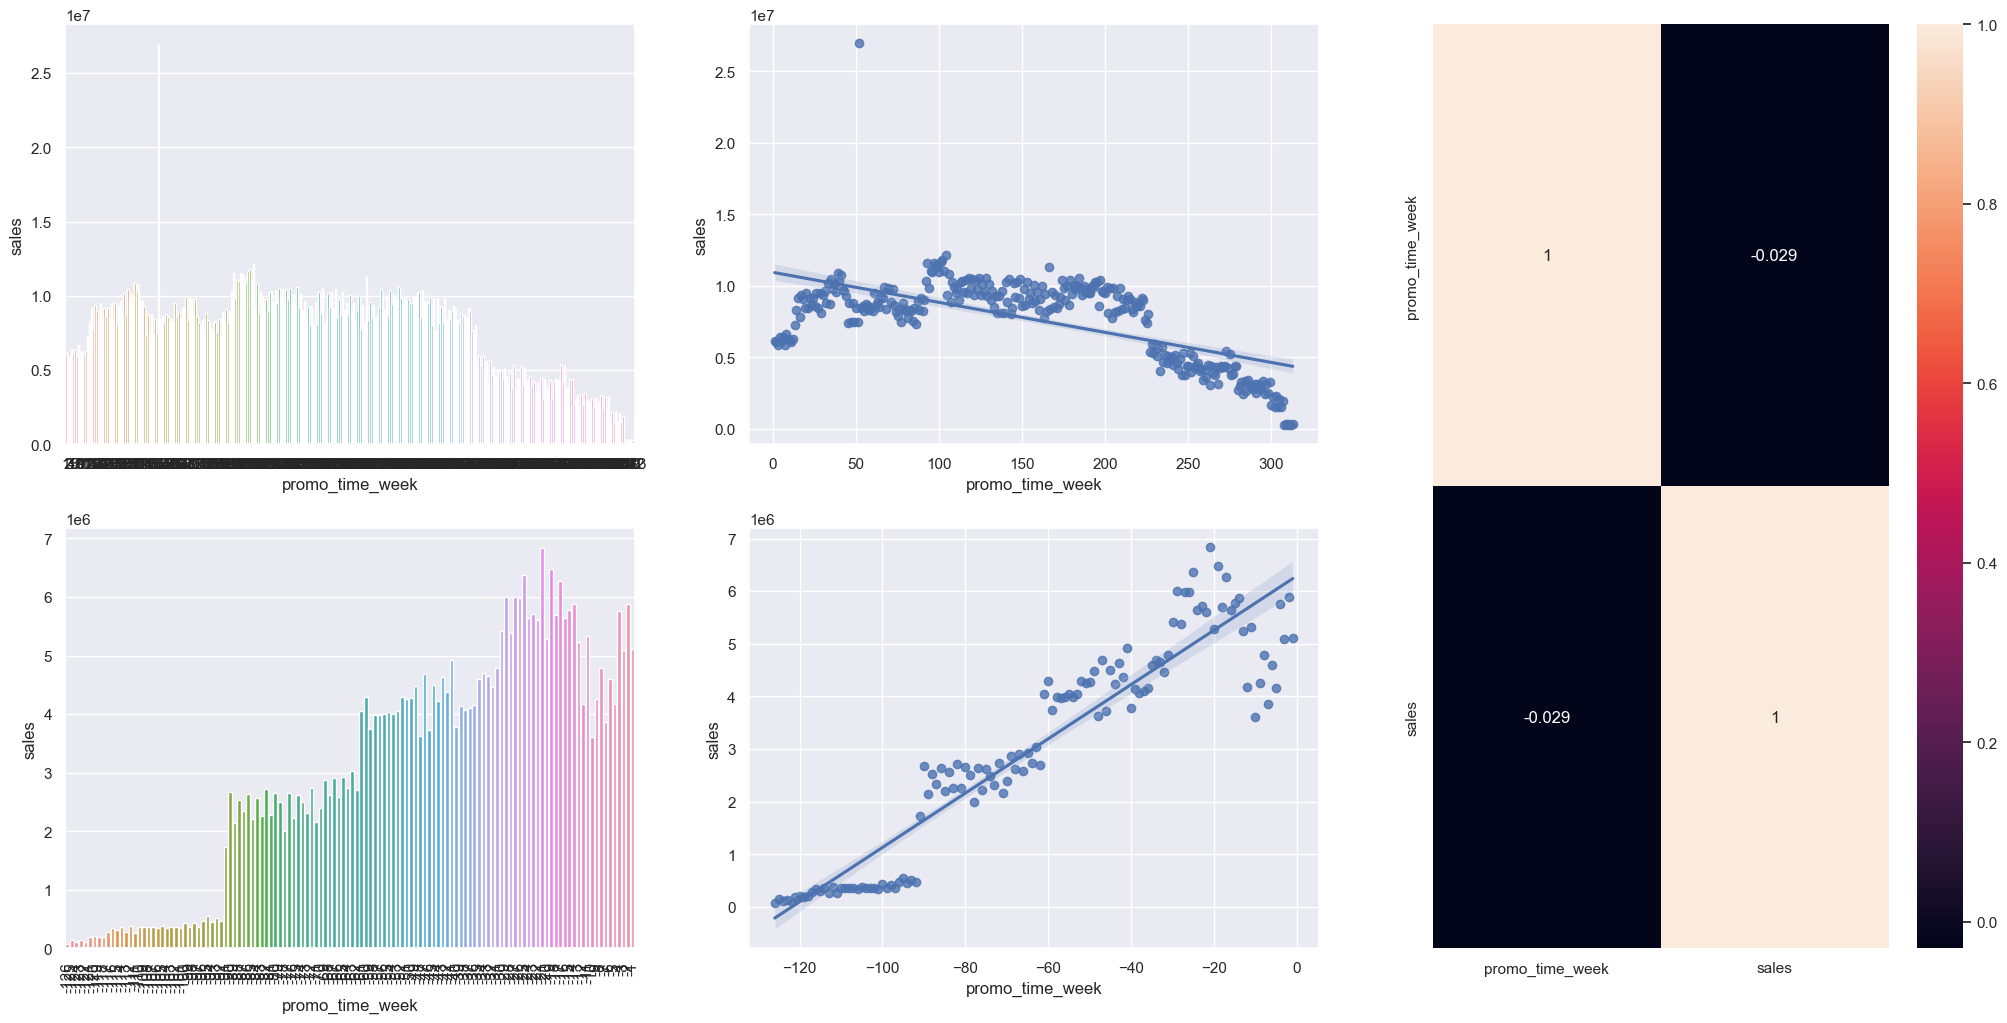

In [300]:
aux1 = df4 [['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec (2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

#Regplot para confirmar a tendencia
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

#Verificando a forca da correlacao
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H5 - Lojas com mais dias de promocao, deveriam vender mais.

### H6 - Lojas com mais promocoes consecutivas, deveriam vender mais.
**False** Lojas com mais promocoes consectivas, na verdade vendem MENOS.

In [301]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


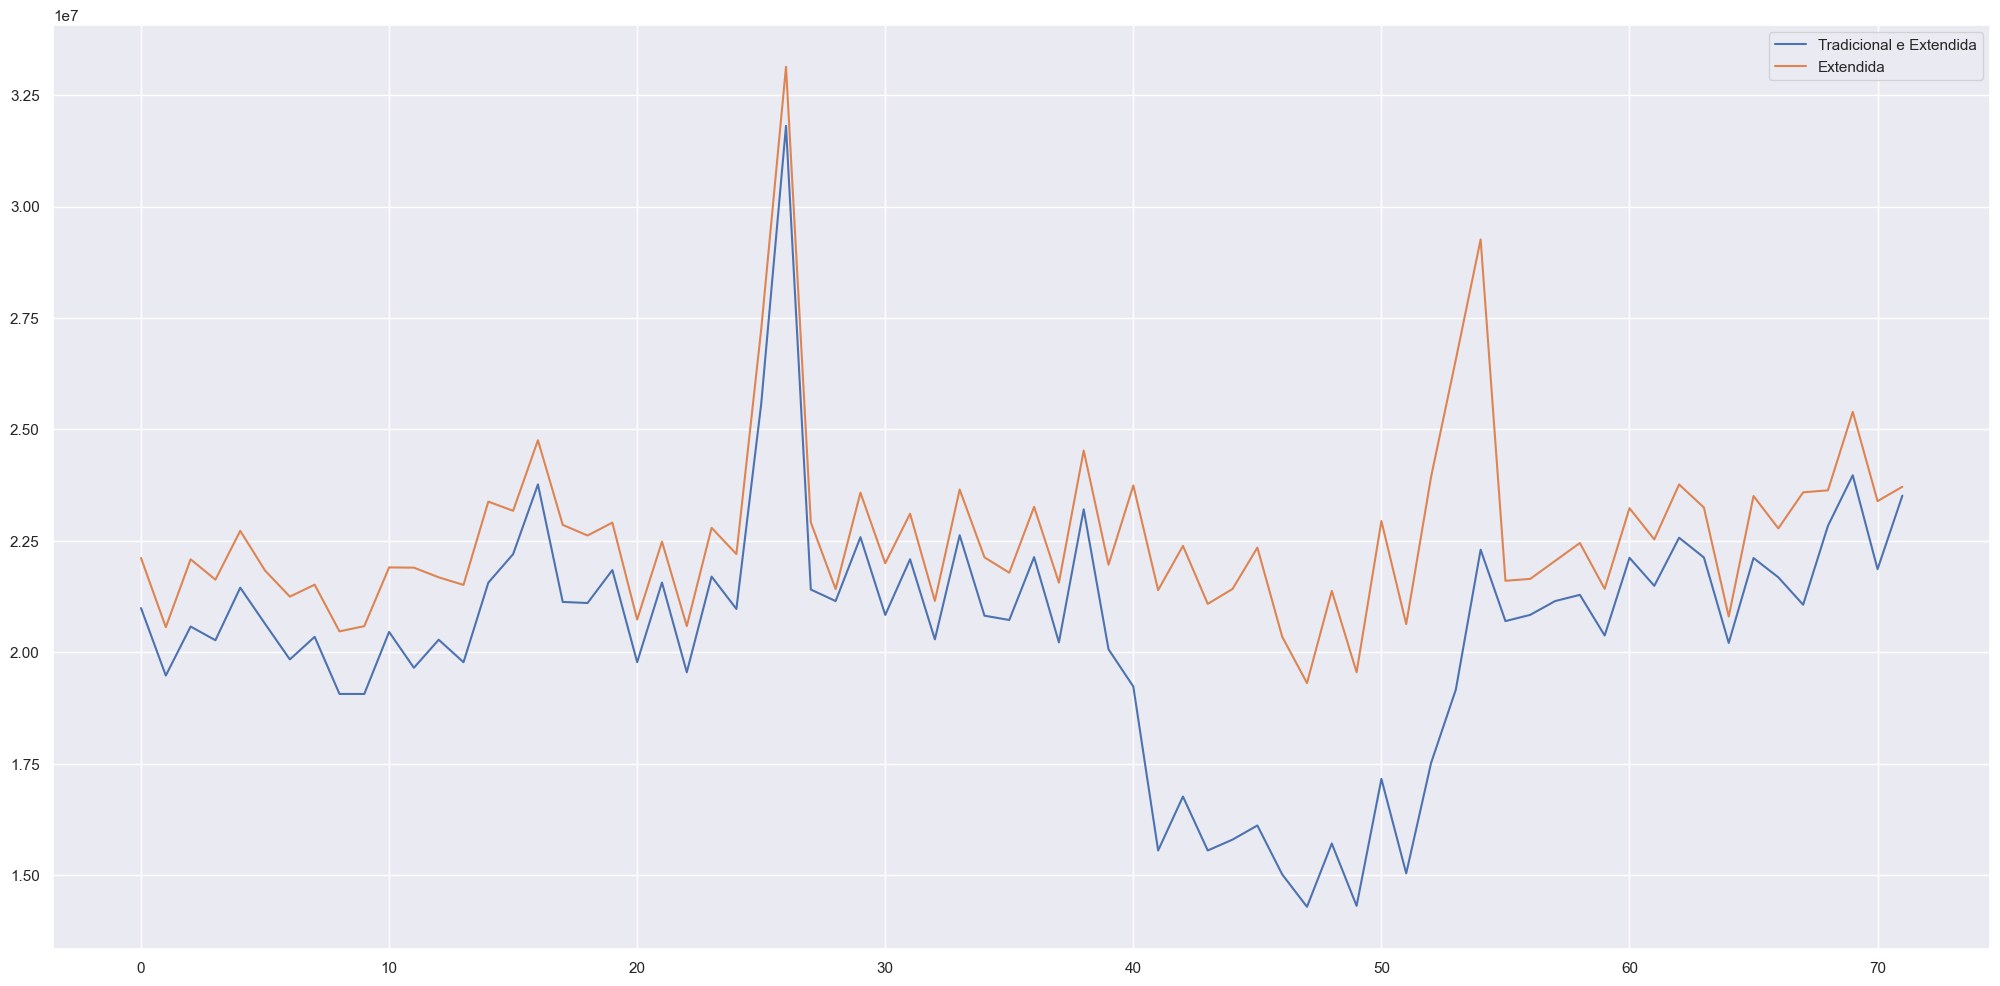

In [302]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida']);

### H7 - Lojas abertas durante o feriado de natal, deveriam vender mais.
**False** Lojas abertas durante o natal na verdade vendem MENOS.

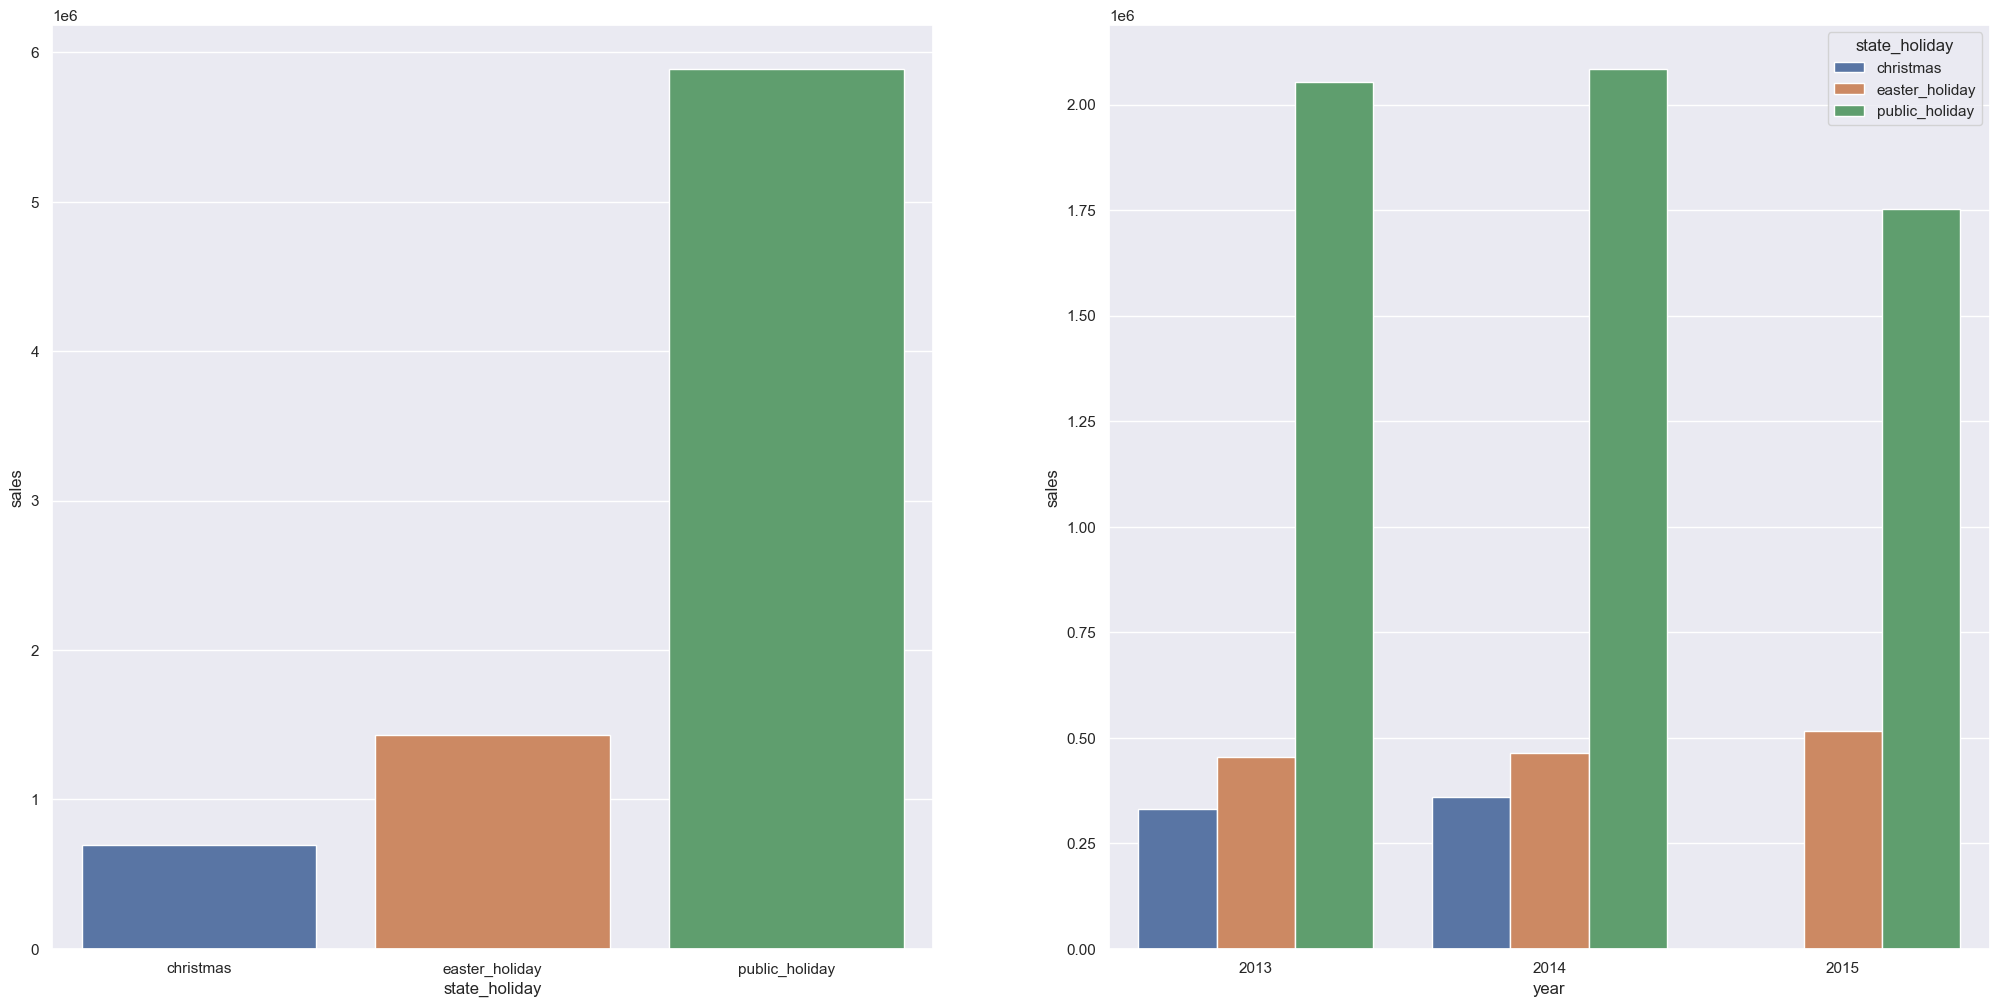

In [303]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux [['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux [['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue = 'state_holiday', data=aux2);

### H8 - Lojas deveriam vender mais ao longo dos anos.
**False** Lojas vendem MENOS ao longo dos anos.

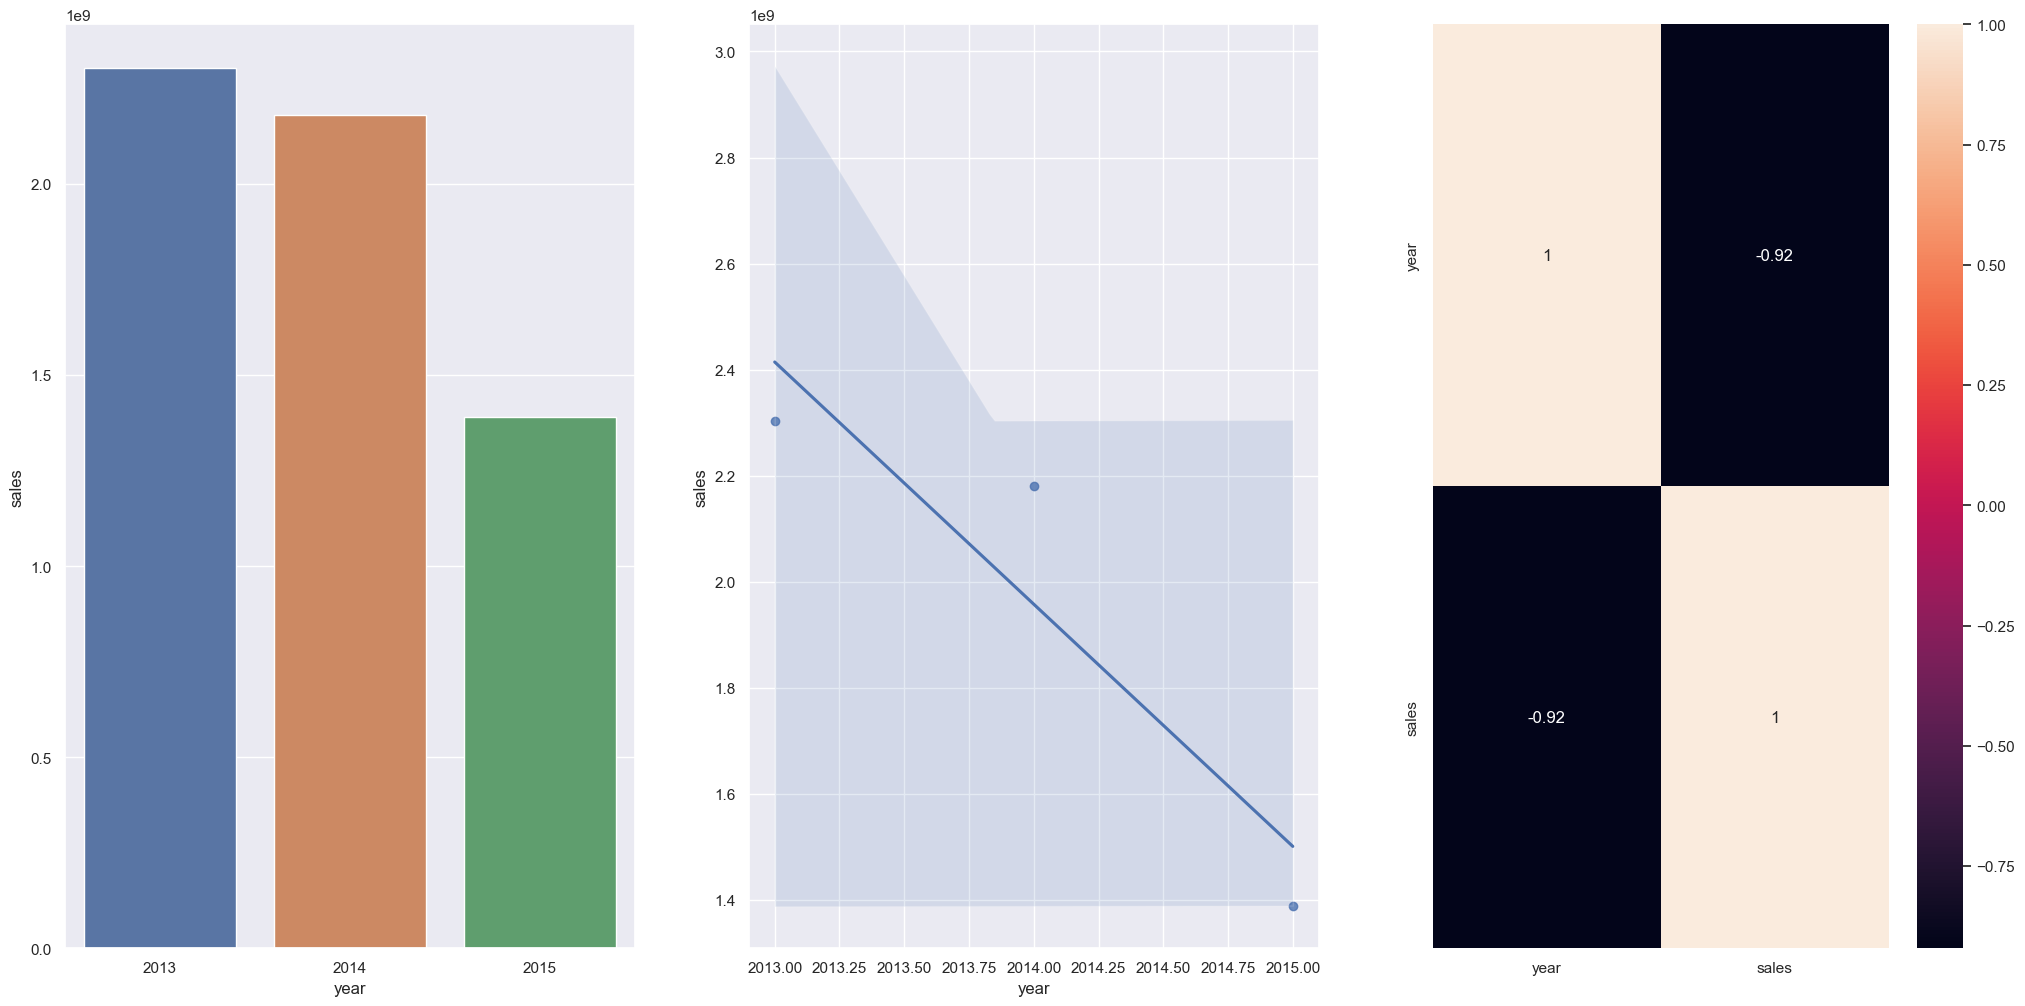

In [304]:
aux1 = df4 [['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 - Lojas deveriam vender mais no segundo semestre do ano.
**False** Lojas vendem MENOS no segundo semestre do ano.

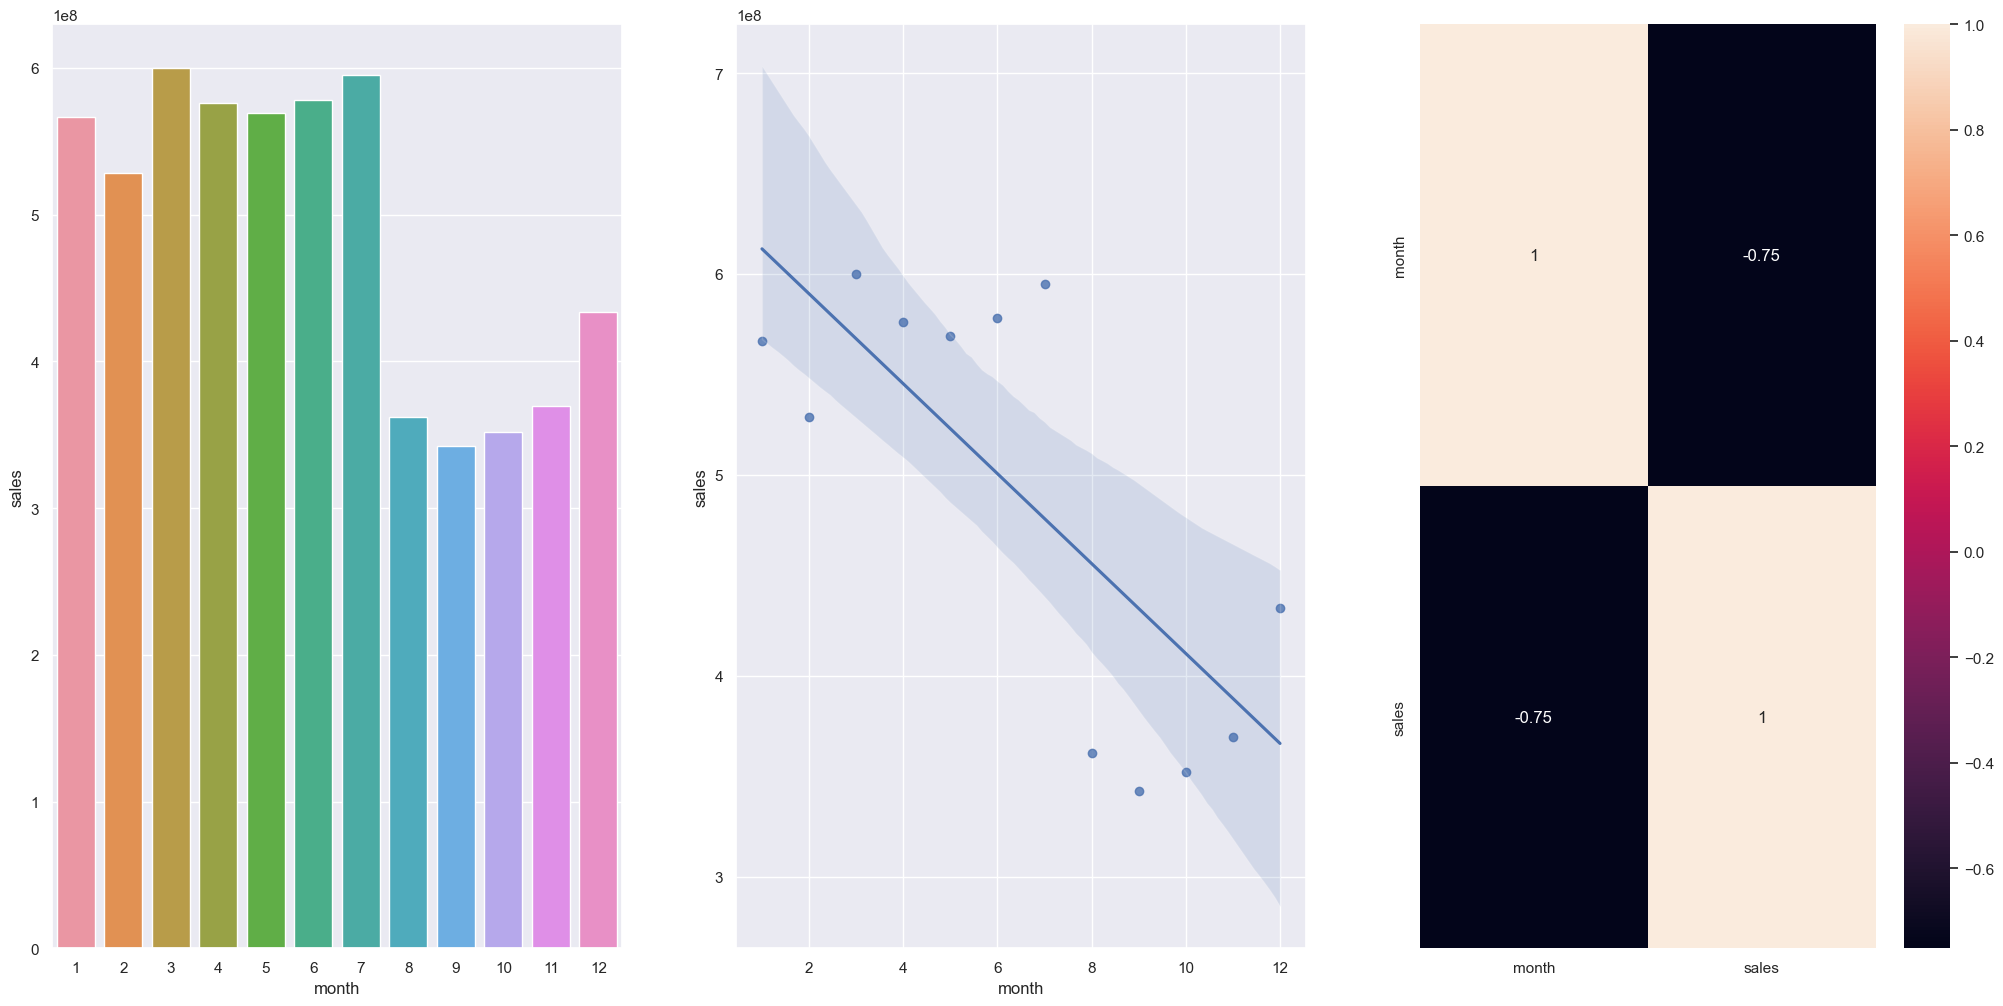

In [305]:
aux1 = df4 [['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10 - Lojas deveriam vender mais, depois do dia 10 de cada mes.
**True** Lojas vendem MAIS depois do dia 10 de cada mes.

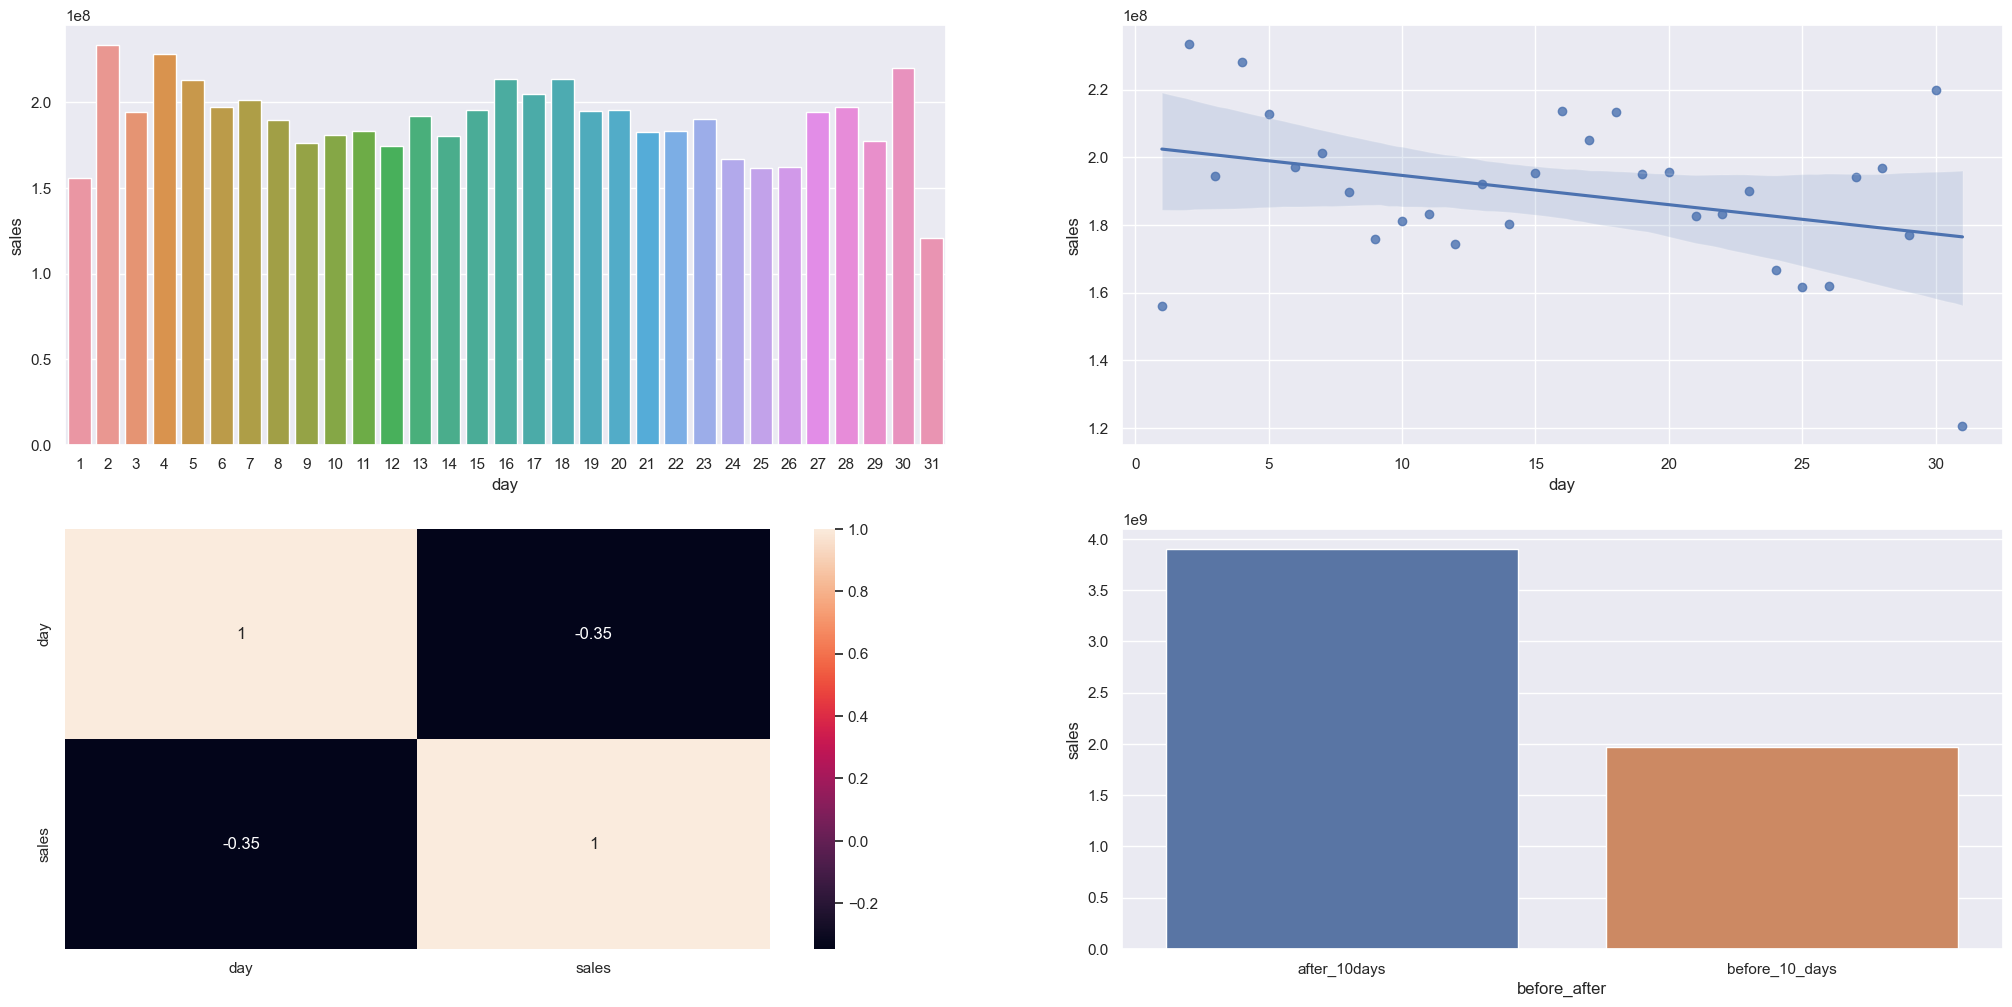

In [306]:
aux1 = df4 [['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1 ['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales', data=aux2);

### H11 - Lojas deveriam vender menos, aos finais de semana.
**True** Lojas vendem MENOS nos finais de semana.

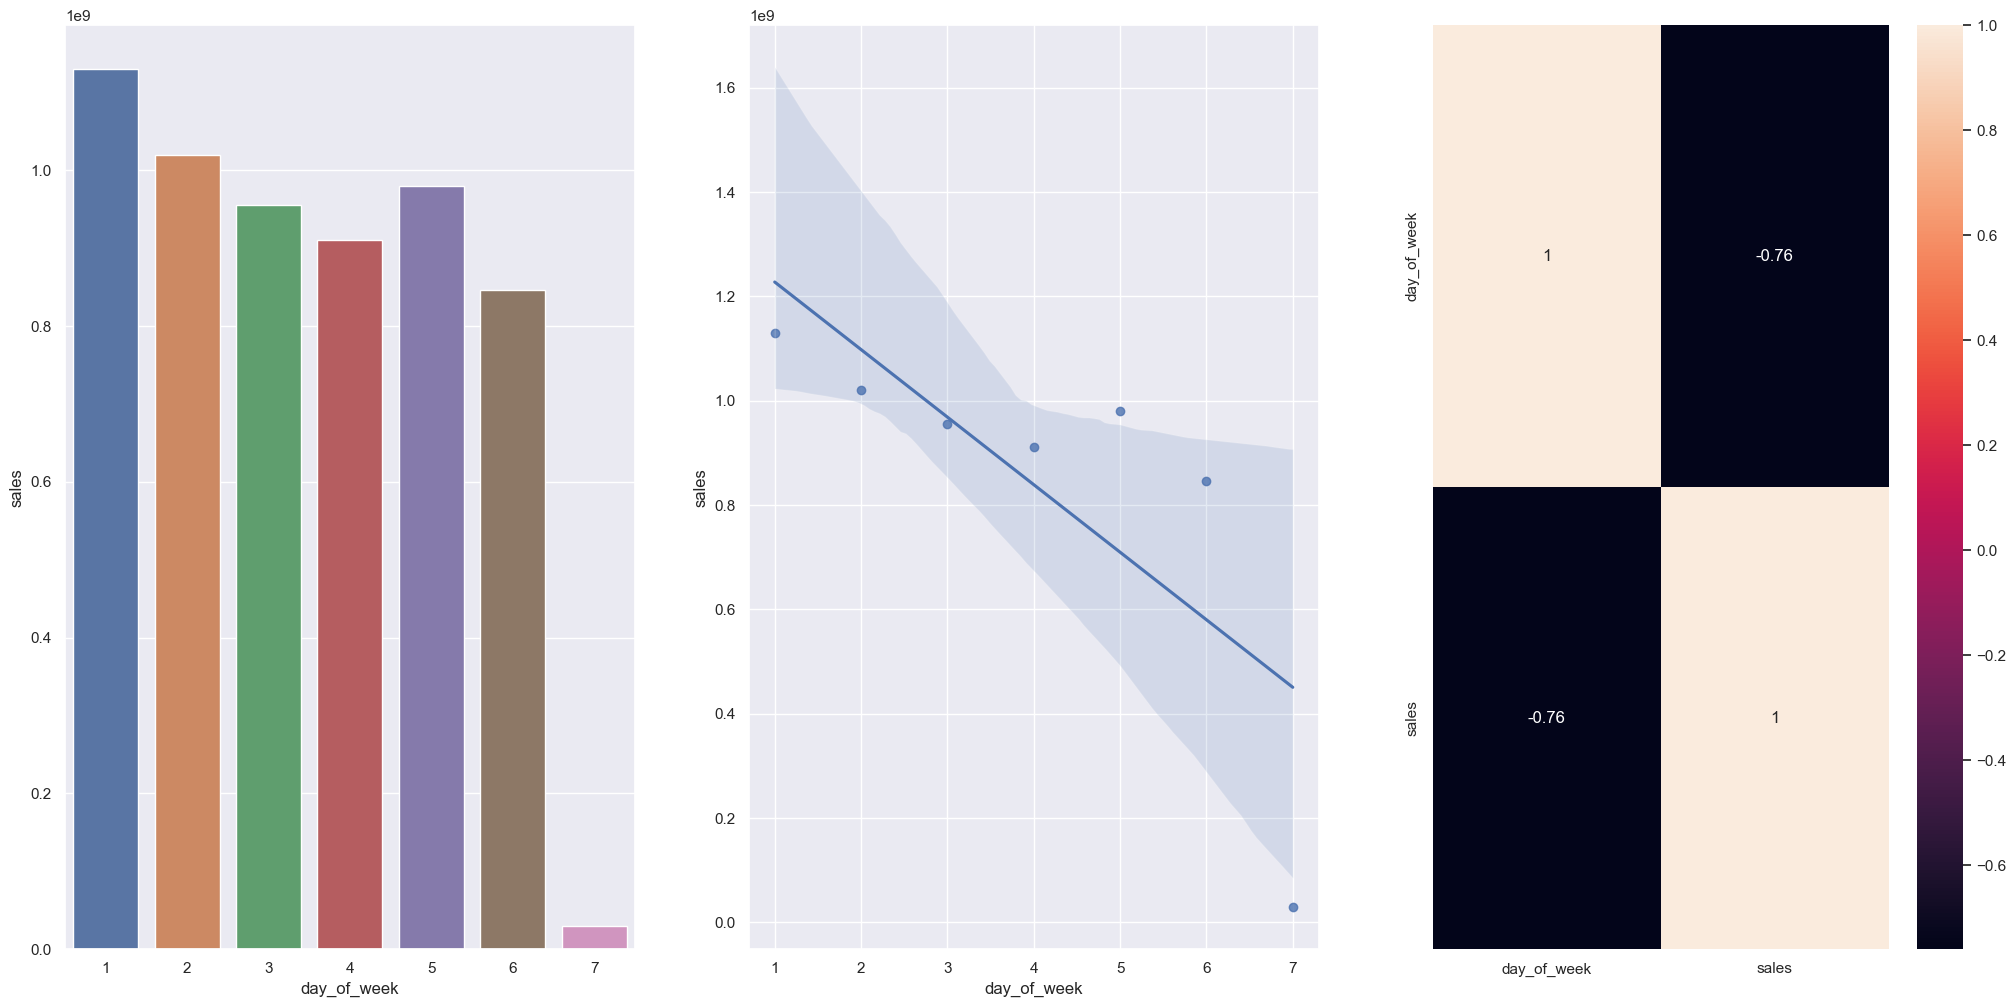

In [307]:
aux1 = df4 [['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12 - Lojas deveriam vender menos, durante os feriados escolares.
**True** Lojas vendem menos nos feriados escolares, exceto nos meses de julho e agosto.

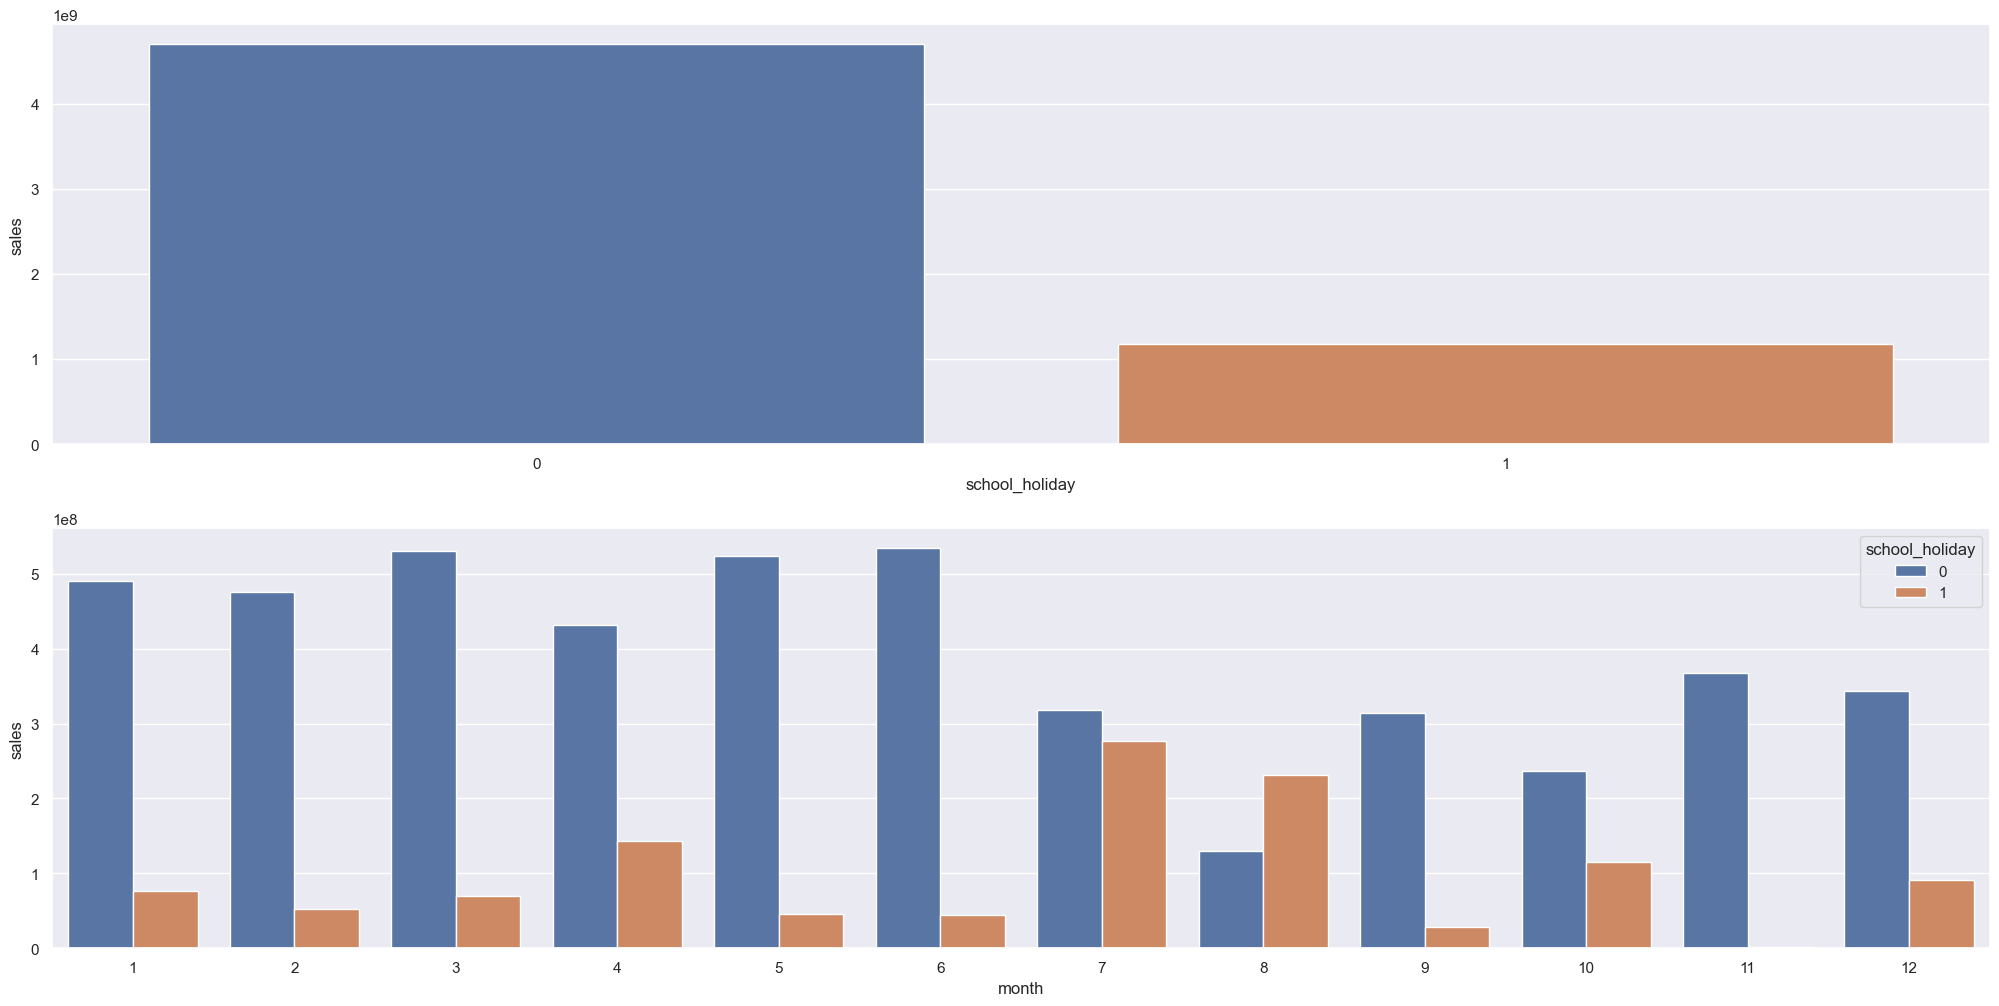

In [308]:
aux1 = df4 [['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4 [['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales', hue='school_holiday', data=aux2);


### 4.2.1 Resumo das Hipoteses

In [309]:
from tabulate import tabulate

In [310]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1','Falsa','Baixa'],
      ['H2','Falsa','Media'],
      ['H3','Falsa','Media'],
      ['H4','Falsa','Baixa'],
      ['H5','-','-'],
      ['H6','Falsa','Baixa'],
      ['H7','Falsa','Media'],
      ['H8','Falsa','Alta'],
      ['H9','Falsa','Alta'],
      ['H10','Verdadeira','Alta'],
      ['H11','Verdadeira','Alta'],
      ['H12','Verdadeira','Baixa'], 
      ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

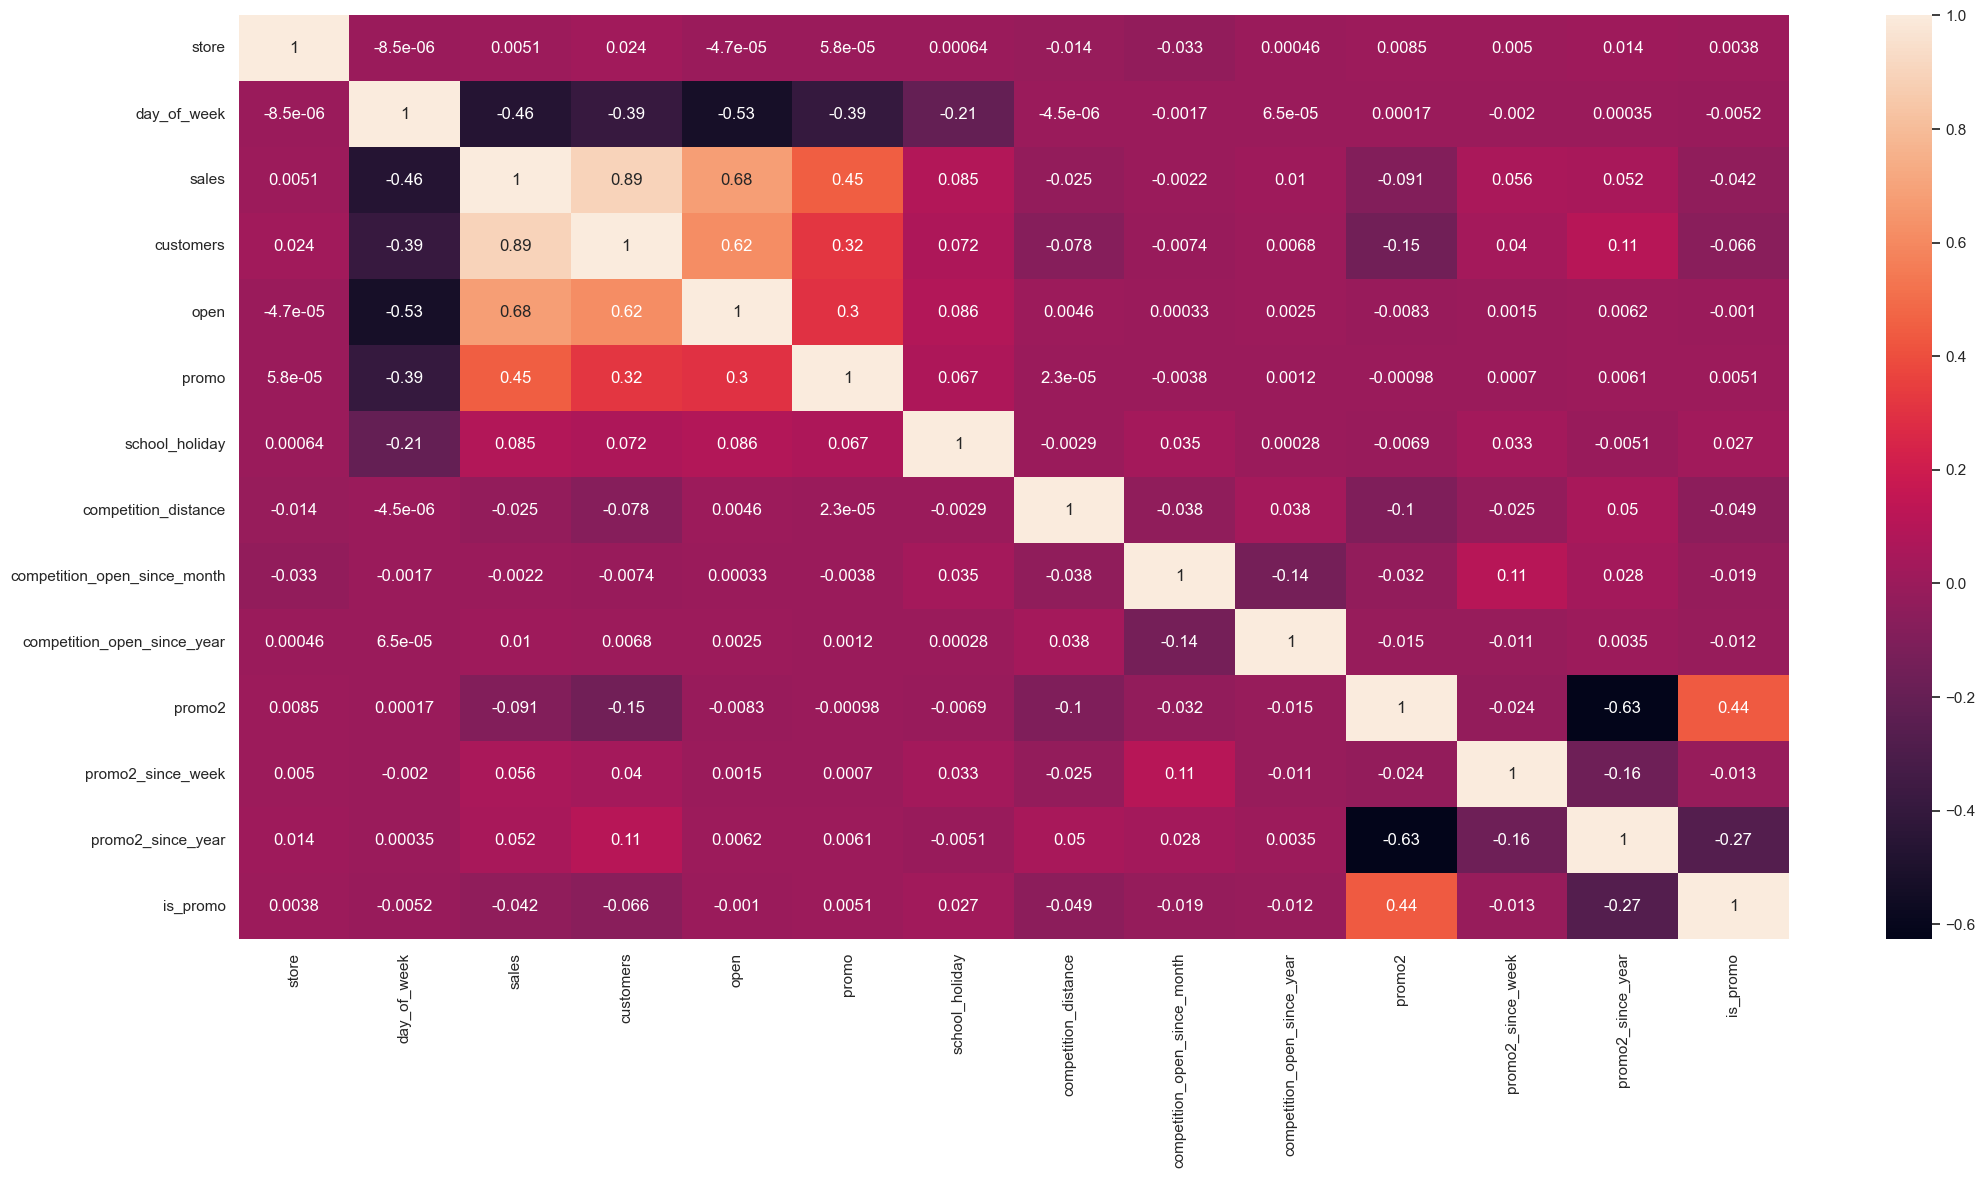

In [311]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [312]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )



NameError: name 'stats' is not defined

# 5.0. DATA PREPARATION

In [313]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [314]:
a = df5.select_dtypes(include=['int64','float64'])

In [315]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


<Axes: >

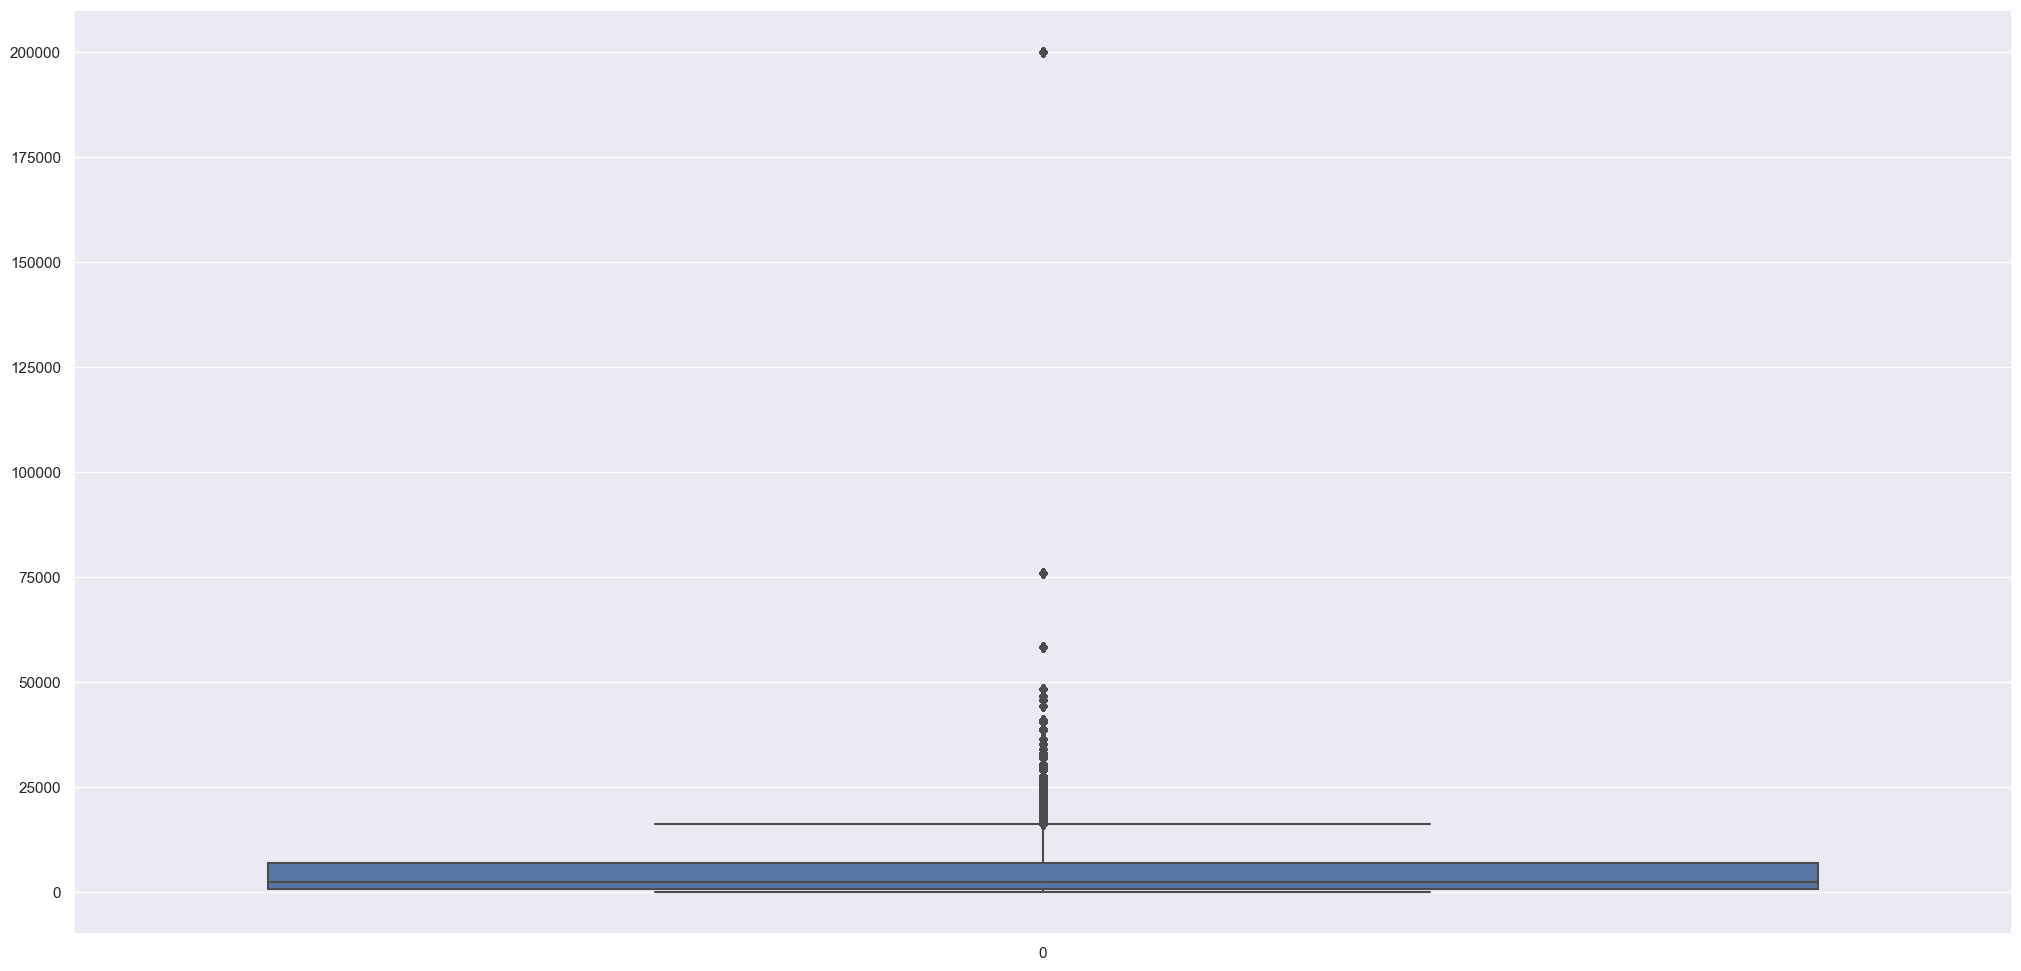

In [316]:
#Verificando se ha outliers nas variaveis
sns.boxplot(df5['competition_distance'])

In [317]:
rs = RobustScaler()
mns = MinMaxScaler()

#competition distance
df5 ['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5 ['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week (nao ha outliers relevantes por isso usamos o MinMaxScaler)
df5 ['promo_time_week'] = mns.fit_transform(df5[['promo_time_week']].values)

#year
df5 ['year'] = mns.fit_transform(df5[['year']].values)



<Axes: xlabel='competition_distance', ylabel='Density'>

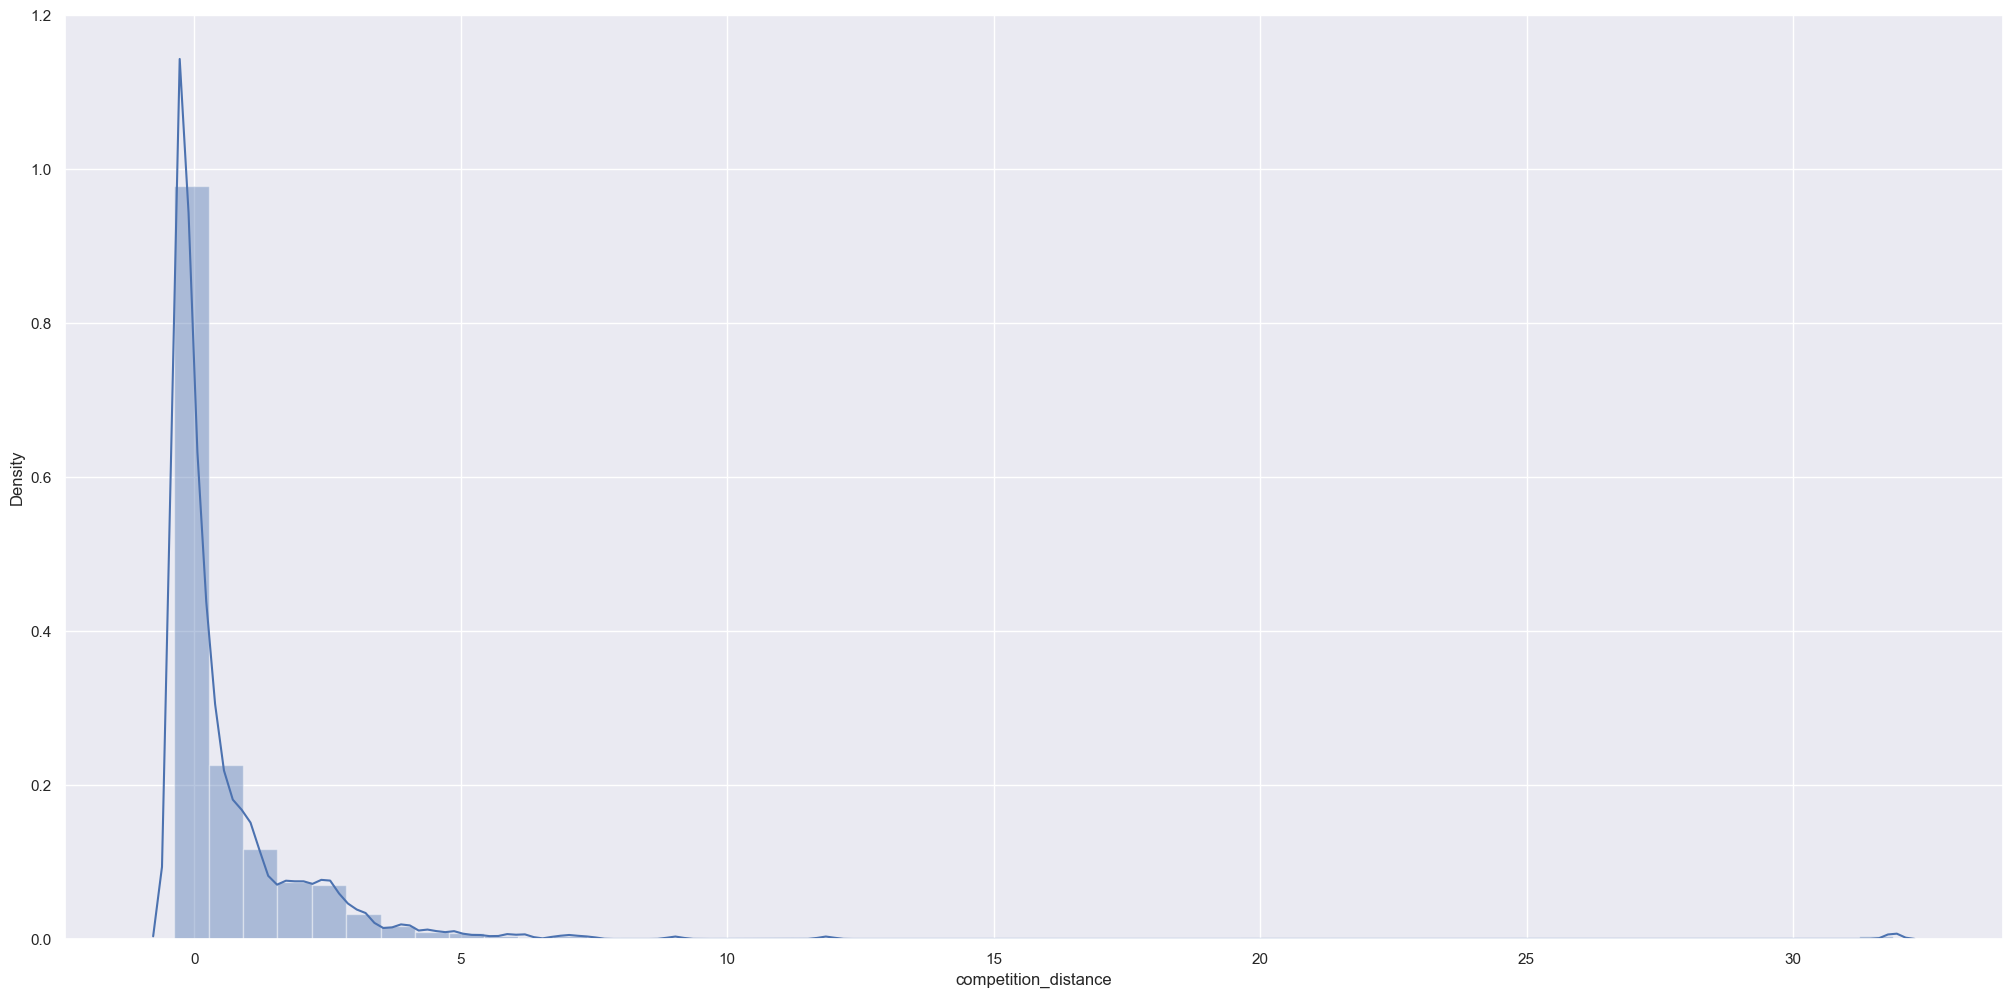

In [318]:
#Verificando mudancas
sns.distplot(df5['competition_distance'])

## 5.3. Transformation

### 5.3.1 Encoding

In [319]:
#Verificando antes do Encoding
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [320]:
#State holiday - One Hot Encoding
df = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#Store type - Label Encoding
le = LabelEncoder()
df5 ['store_type'] = le.fit_transform (df5['store_type'])

#Assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [321]:
#Verificando Encoding
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


### 5.3.2 Response Variable Transformation

<Axes: xlabel='sales', ylabel='Density'>

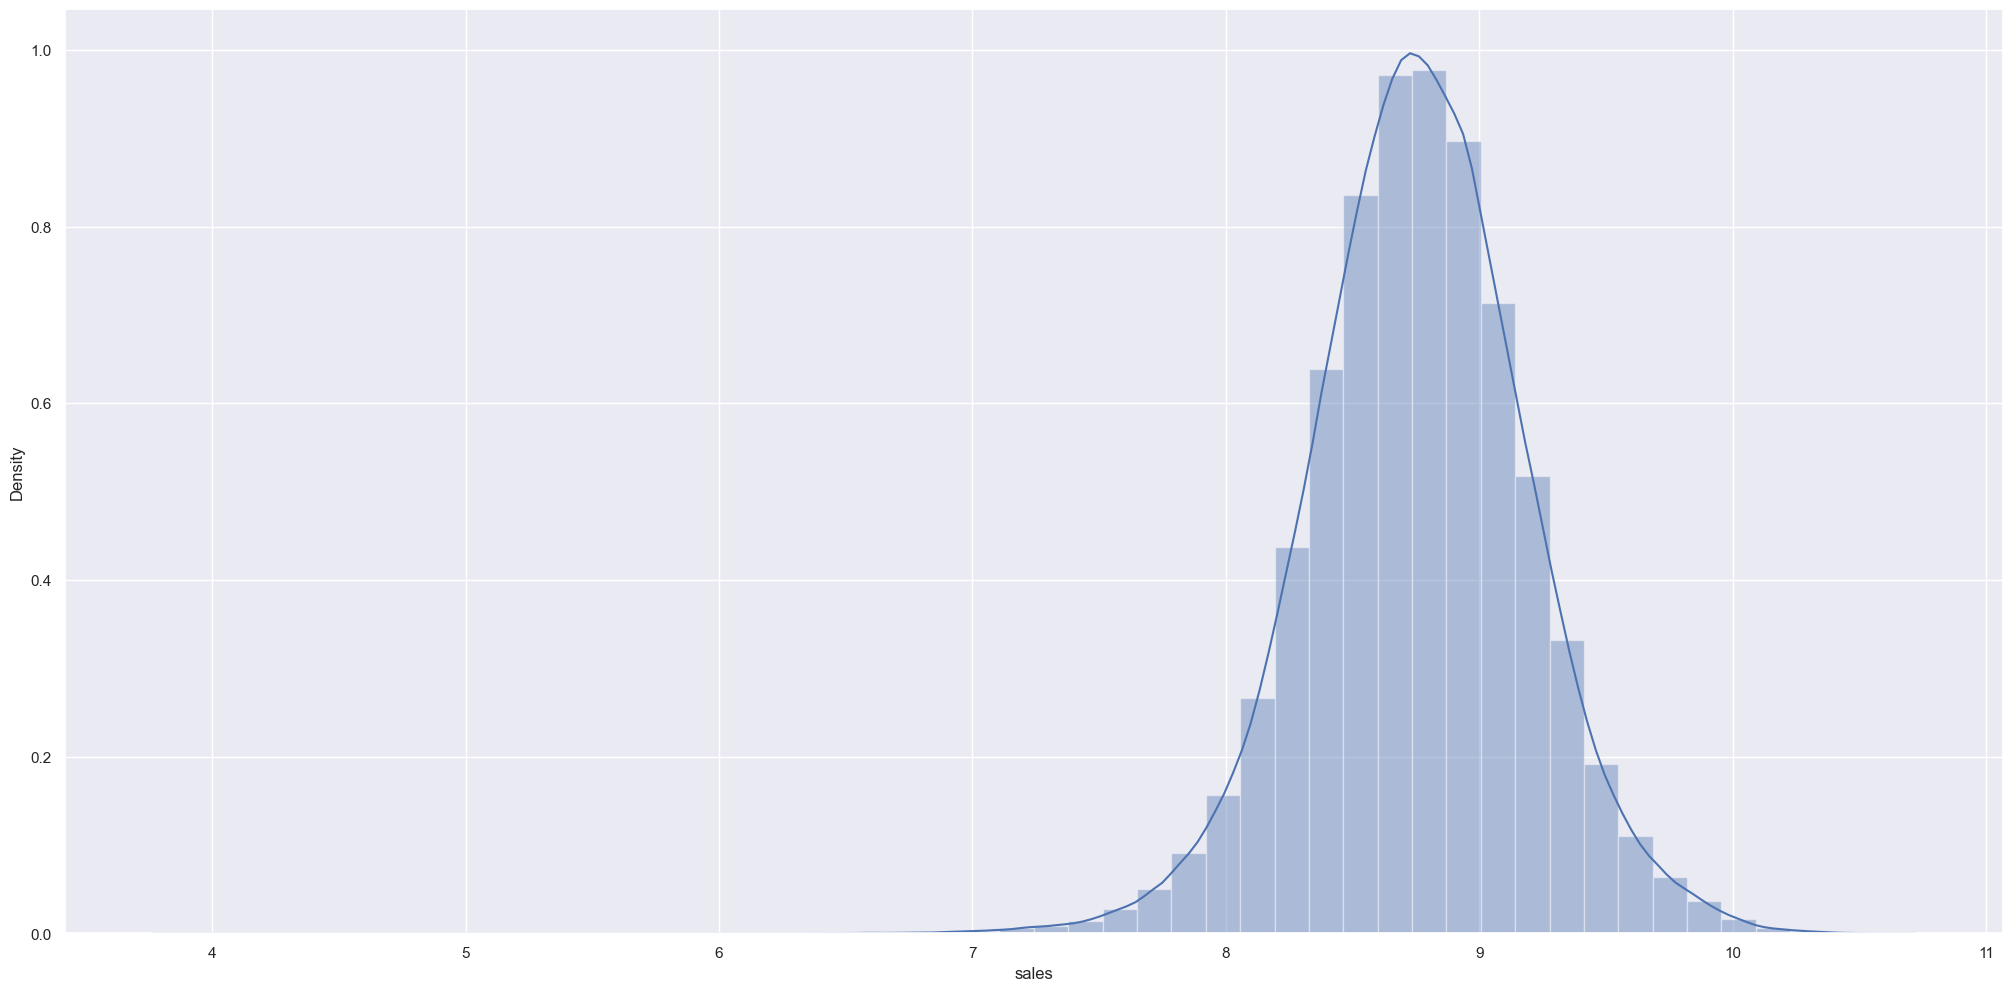

In [322]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation (Variaveis com natureza ciclica)

In [323]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )


In [324]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,regular_day,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,regular_day,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,regular_day,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,regular_day,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,regular_day,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [325]:
df6 = df5.copy()

## 6.1. Split dataframe into training test dataset

In [326]:
df6.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,regular_day,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,regular_day,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,regular_day,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,regular_day,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,regular_day,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [327]:
#Variaveis que serao deletadas
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

#Filtrando o dataset sem as colunas que serao dropadas
df6 = df6.drop (cols_drop, axis=1)

In [328]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as feature selector

In [329]:
#training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


### 6.2.1. Best Features from Boruta

In [330]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )


 ## 6.3. Manual Feature Selection

In [331]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']
# columns to add
feat_to_add = ['date', 'sales']

#Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


# 7.0. MACHINE LEARNING MODELLING

In [332]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Avarage Model

In [333]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [334]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [335]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model = Lasso

In [336]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


###  7.3.1. Lasso - Cross Validation


In [337]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor


In [338]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [339]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5. XGBoost Regressor

In [340]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

[11:05:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.667628,0.949516,7330.817866


###  7.5.1. XGBoost Regressor - Cross Validation


In [341]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv



KFold Number: 5
[11:08:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 4
[11:10:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 3
[11:12:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 2
[11:15:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.


KFold Number: 1
[11:17:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.98 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance

In [342]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.667628,0.949516,7330.817866


### 7.6.2. Real Performance - Cross Validation

In [343]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7047.98 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0. HYPERPARAMETER FINE TUNING


## 8.1. Random Search

In [ ]:
#param = {
#   'n_estimators': [1500, 1700, 2500, 3000, 3500],
#   'eta': [0.01, 0.03],
#   'max_depth': [3, 5, 9],
#   'subsample': [0.1, 0.5, 0.7],
#   'colsample_bytree': [0.3, 0.7, 0.9],
#   'min_child_weight': [3, 8, 15]
#       }
#
#MAX_EVAL = 5

In [ ]:
 #final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#  
#   # performance
#   result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
#   final_result = pd.concat( [final_result, result] )
#
#final_result

In [ ]:
#final_result

 ## 8.2. Final Model

In [344]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }

In [345]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned


[11:42:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.460211,0.114435,1090.29311
